In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/analysisTools")
import plotTools as ptools

In [2]:
f_sig = "signal_2018_aEM.coffea"
sig = util.load(f_sig)[0]
f_sig = "signal_2018_aEM_ejdR_rejection.coffea"
sig_rej = util.load(f_sig)[0]

In [3]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

In [4]:
cut='cut13'

In [5]:
def plot(hname,xlim,extra=None,rej=False,rebin=1j,logy=False,scaley=5,xlabel=None,density=False,ylim=None):
    for delta in deltas:
        plt.figure(figsize=(16,4))
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for i,ct in enumerate(ctaus):
            plt.subplot(1,4,i+1)
            plt.title(r"$c\tau = {0}$ mm".format(ct))
            for m1 in m1s:
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                if rej:
                    hs = sig_rej[hname]
                else:
                    hs = sig[hname]
                if extra is not None:
                    hs = extra(hs)[{"samp":point,"cut":cut}][::rebin]
                else:
                    hs = hs[{"samp":point,"cut":cut}][::rebin]
                hs.plot1d(label=r"$M_1 = {0}$".format(m1),yerr=False,density=density)
            
            if logy:
                plt.yscale('log')
            if xlim:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            if ylim:
                plt.ylim(ylim)
            else:
                plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            
            ncol = min((len(m1s)+1) // 2 + (len(m1s)+1)%2,3)
            if i==0:
                plt.gca().legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=7,ncol=ncol)
        
        plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        plt.savefig(f"plots/histos/sigOnly_{hname}_delta{delta:.1f}.pdf")
        plt.tight_layout()

In [6]:
def plot_compare(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,density=False,ylim=None):
    for delta in deltas:
        plt.figure(figsize=(16,4))
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for i,ct in enumerate(ctaus):
            plt.subplot(1,4,i+1)
            plt.title(r"$c\tau = {0}$ mm".format(ct))
            for j,m1 in enumerate(m1s):
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][point,cut,::rebin]
                hs_rej = sig_rej[hname][point,cut,::rebin]
                hs.plot1d(label=r"$M_1 = {0}$".format(m1),yerr=False,density=density,color=f"C{j}")
                hs_rej.plot1d(label="w/ jet dR rejection".format(m1),yerr=False,density=density,color=f"C{j}",linestyle='--')
                
            
            if logy:
                plt.yscale('log')
            if xlim:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            if ylim:
                plt.ylim(ylim)
            else:
                plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            
            ncol = min((len(m1s)+1) // 2 + (len(m1s)+1)%2,3)
            if i==0:
                plt.gca().legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=7,ncol=ncol)
        
        plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        plt.savefig(f"plots/histos/sigOnly_{hname}_delta{delta:.1f}_jetRejVsDefault.pdf")
        plt.tight_layout()

In [7]:
def plot2d(hname,rebinx=1j,rebiny=1j,logy=False,scaley=5,xlabel=None,density=False,xlim=None,ylim=None,save=False):
    for delta in [0.1,0.2]:
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for m1 in m1s:
            plt.figure(figsize=(16,4))
            for i,ct in enumerate(ctaus):
                plt.subplot(1,4,i+1)
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebinx,::rebiny]
                hs.plot2d(flow=True)
                plt.title(r"$m_1 = {0:.1f}$, $\Delta = {1:.1f}$, $c\tau = {2}$ mm".format(m1,delta,ct))
                if xlim:
                    plt.xlim(xlim)
                if ylim:
                    plt.ylim(ylim)
                """if logy:
                    plt.yscale('log')
                if xlim:
                    plt.xlim(xlim)
                ylo,yhi = plt.gca().get_ylim()
                if ylim:
                    plt.ylim(ylim)
                else:
                    plt.ylim([ylo,scaley*yhi])
                if xlabel:
                    plt.xlabel(xlabel)

                ncol = min((len(m1s)+1) // 2 + (len(m1s)+1)%2,3)
                if i==0:
                    plt.gca().legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=7,ncol=ncol)"""
            plt.tight_layout()
            if save:
                plt.savefig(f"plots/histos_2d/sigOnly_{hname}_m1{m1:.1f}_delta{delta:.1f}.png")

# Plot vertex match types

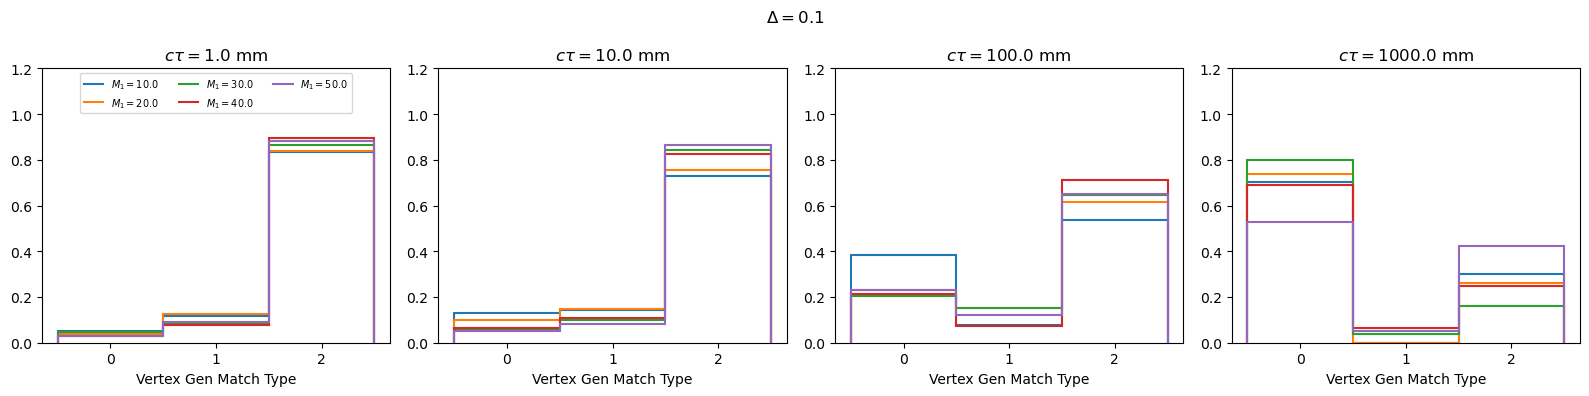

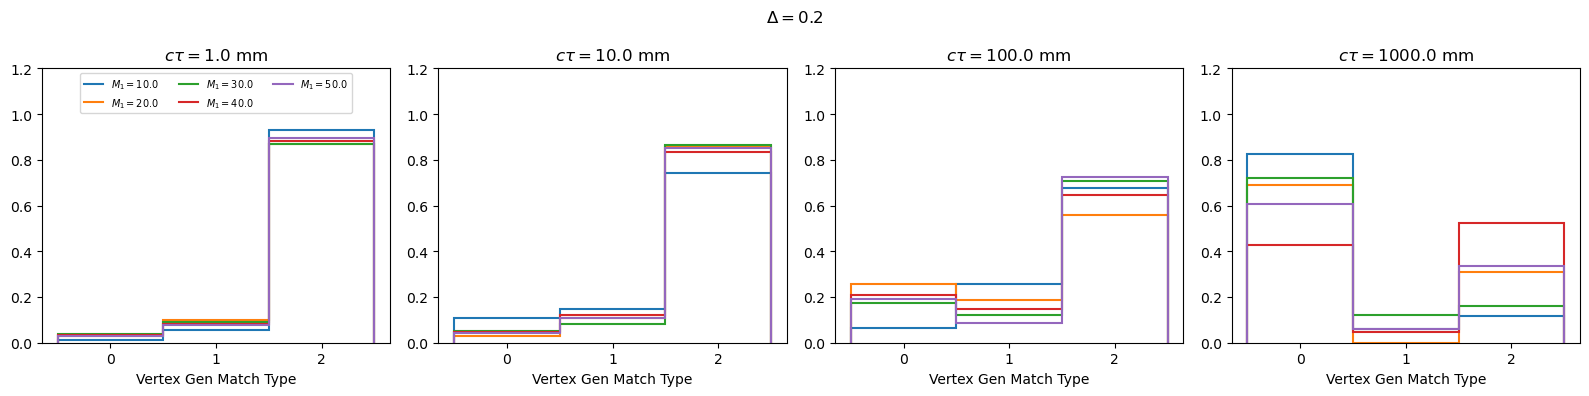

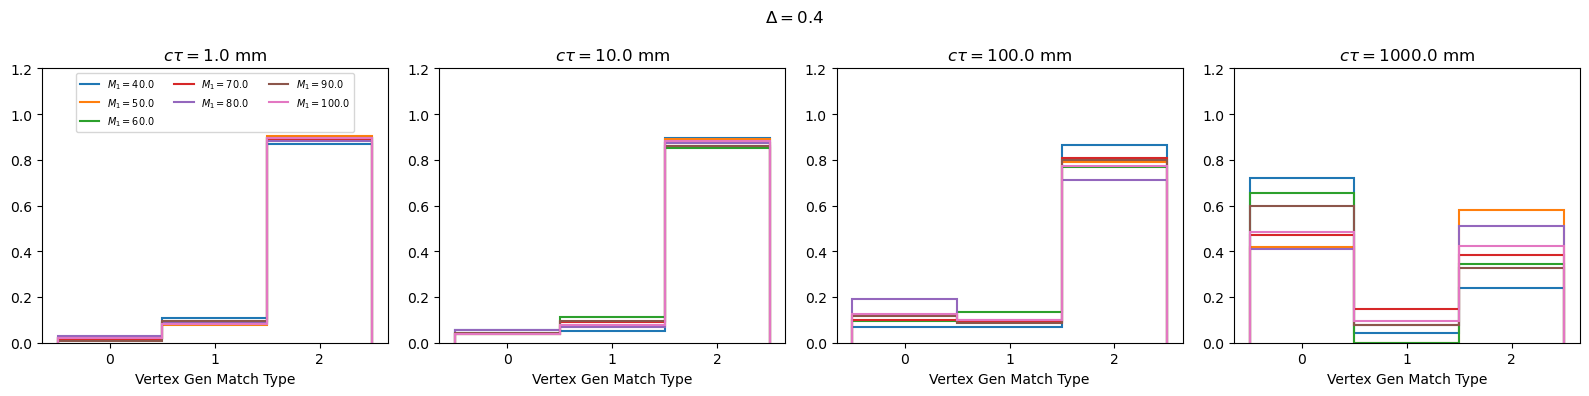

In [8]:
# electron 1 PF isolation dR < 0.3
plot("sel_vtx_matchType",None,logy=False,rebin=1j,density=True,ylim=[0,1.2])

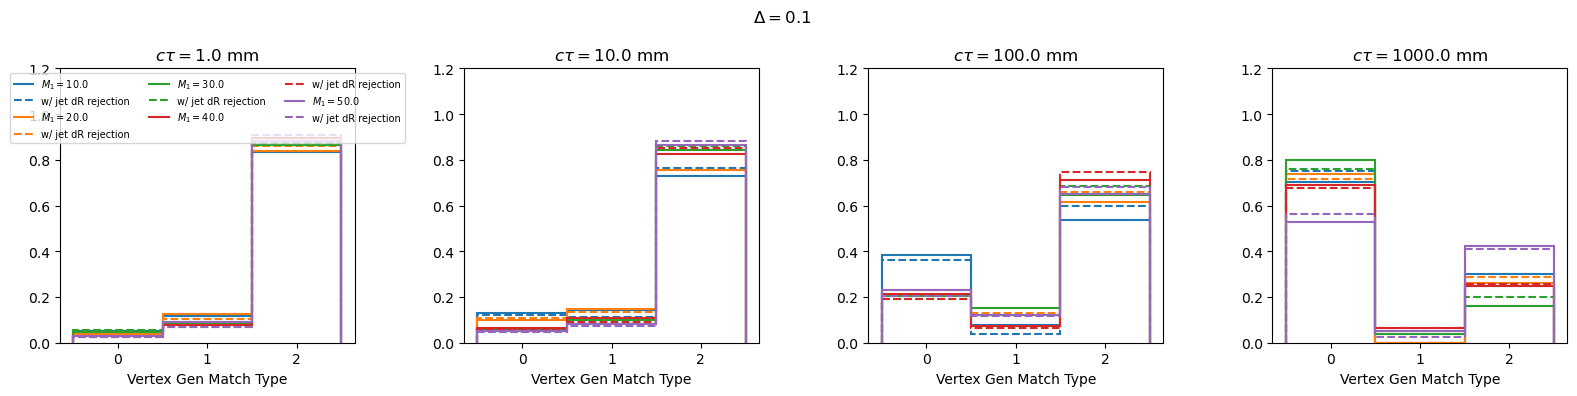

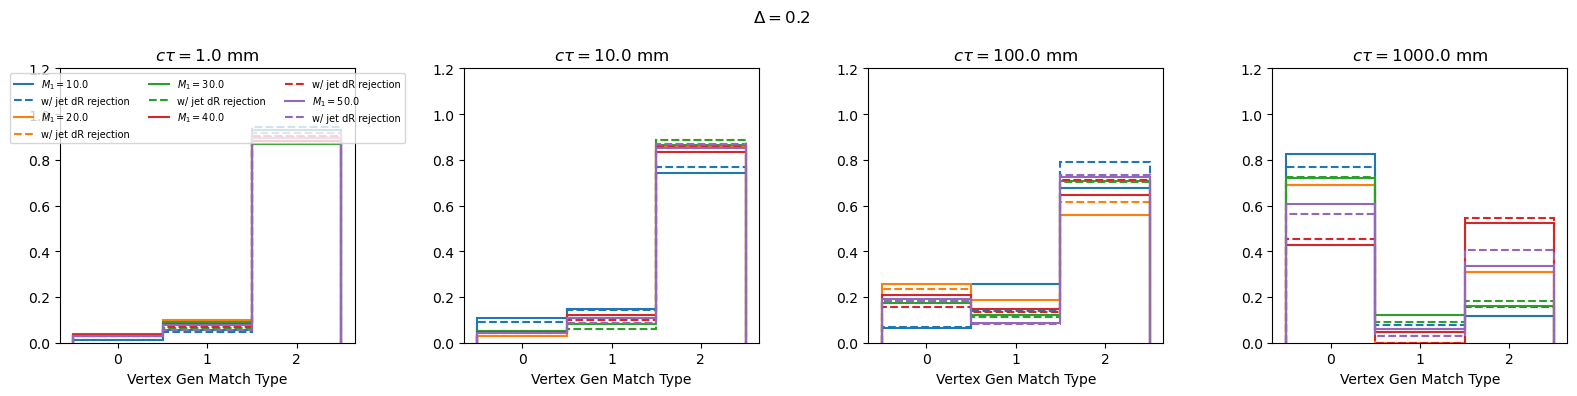

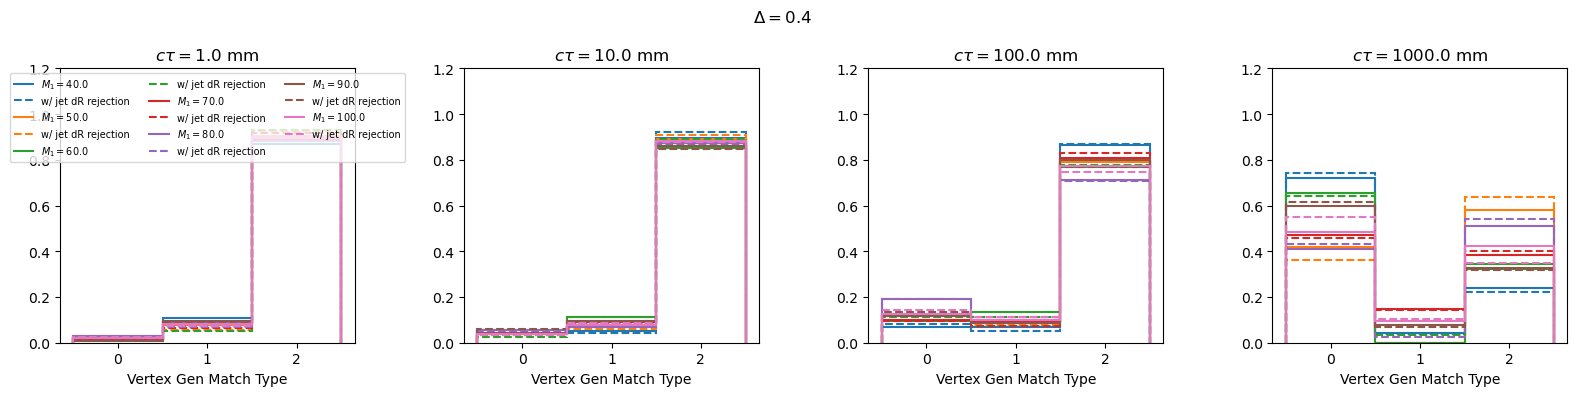

In [9]:
# electron 1 PF isolation dR < 0.3
plot_compare("sel_vtx_matchType",None,logy=False,rebin=1j,density=True,ylim=[0,1.2])

# Gen electron-vertex dR

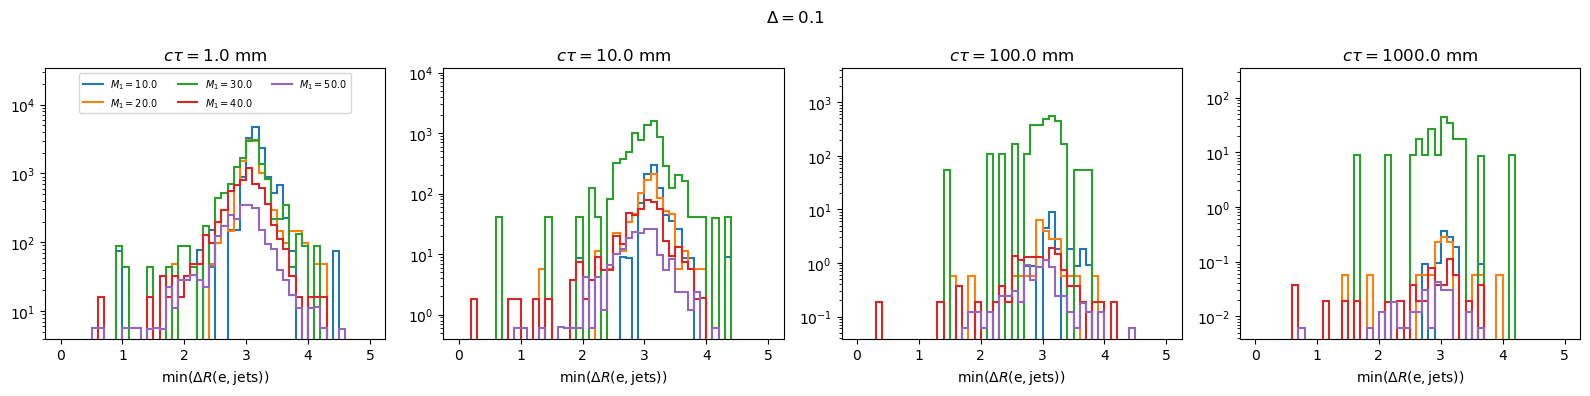

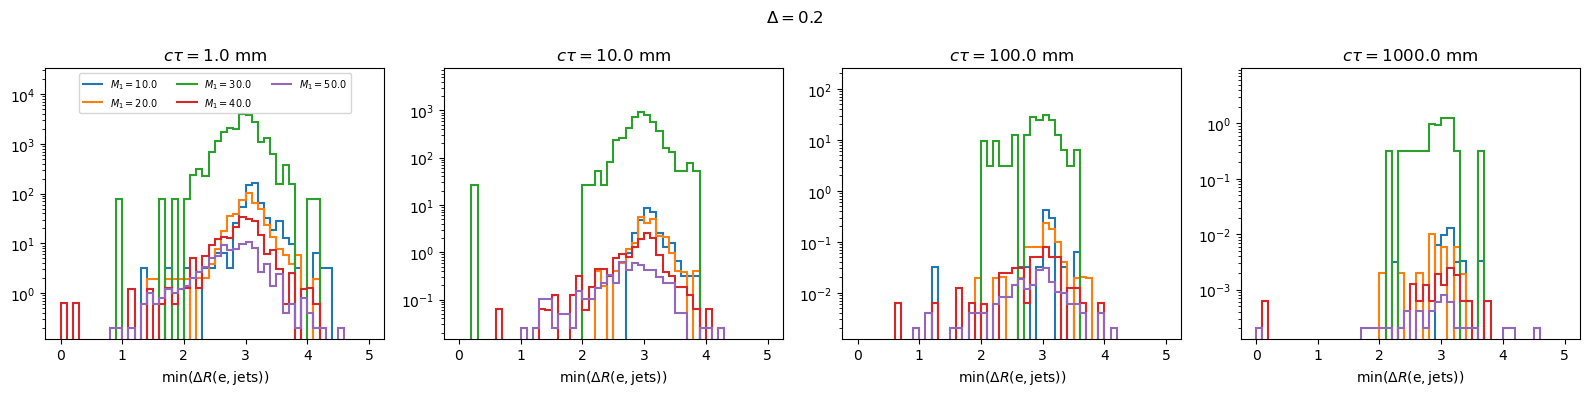

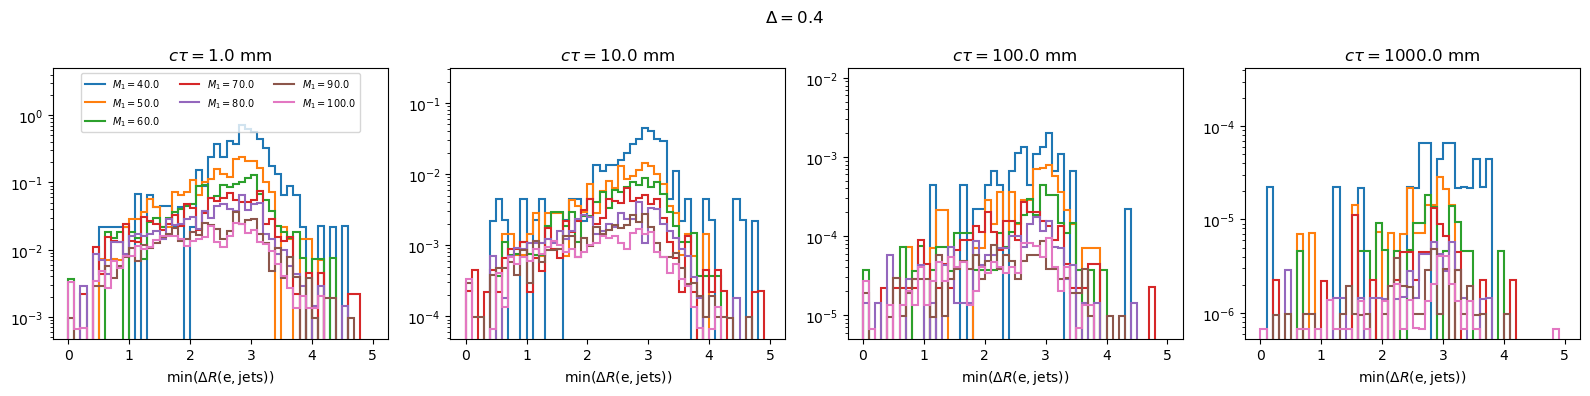

In [10]:
# electron 1 PF isolation dR < 0.3
plot("genEle_mindRj",None,rej=True,logy=True,rebin=1j)

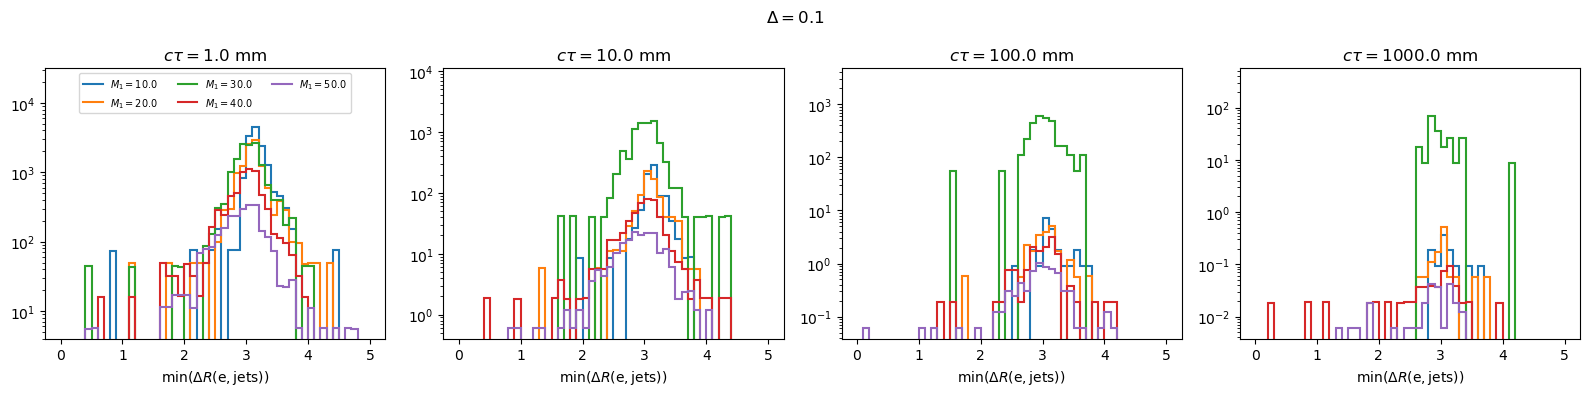

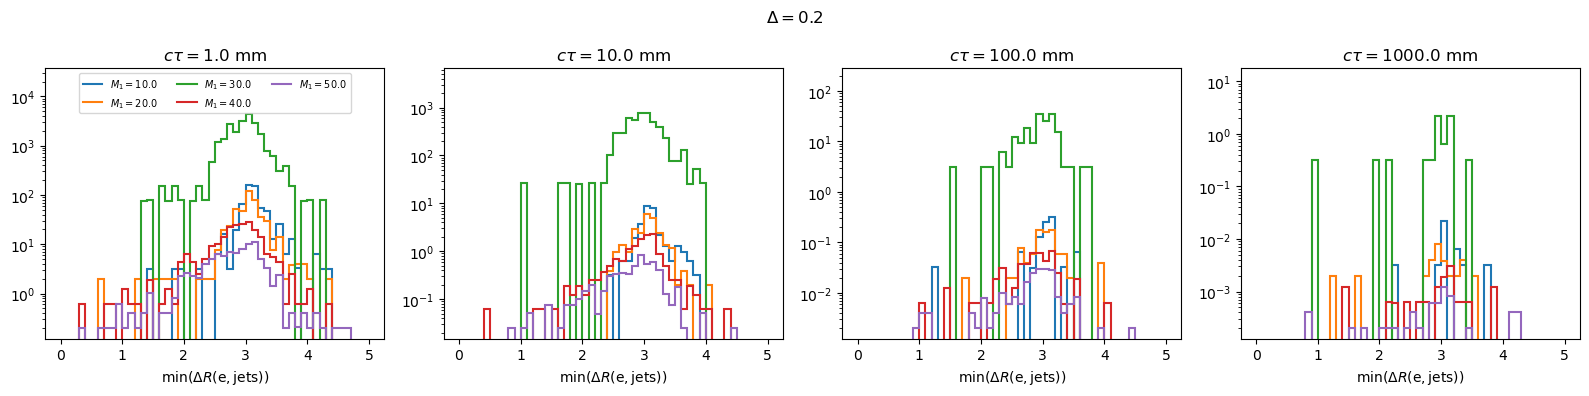

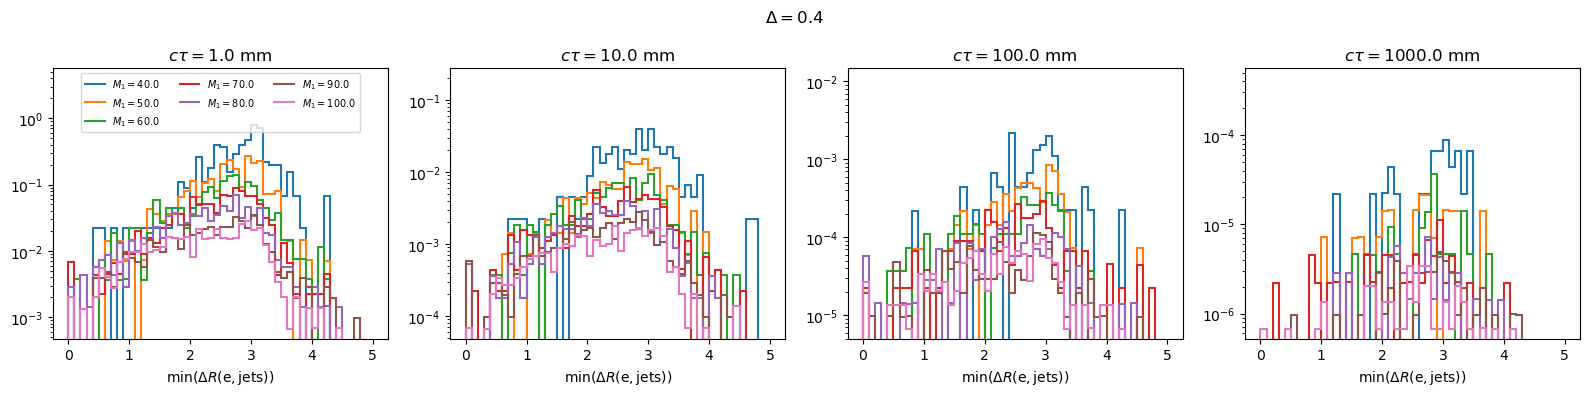

In [11]:
# electron 1 PF isolation dR < 0.3
plot("genPos_mindRj",None,rej=True,logy=True,rebin=1j)

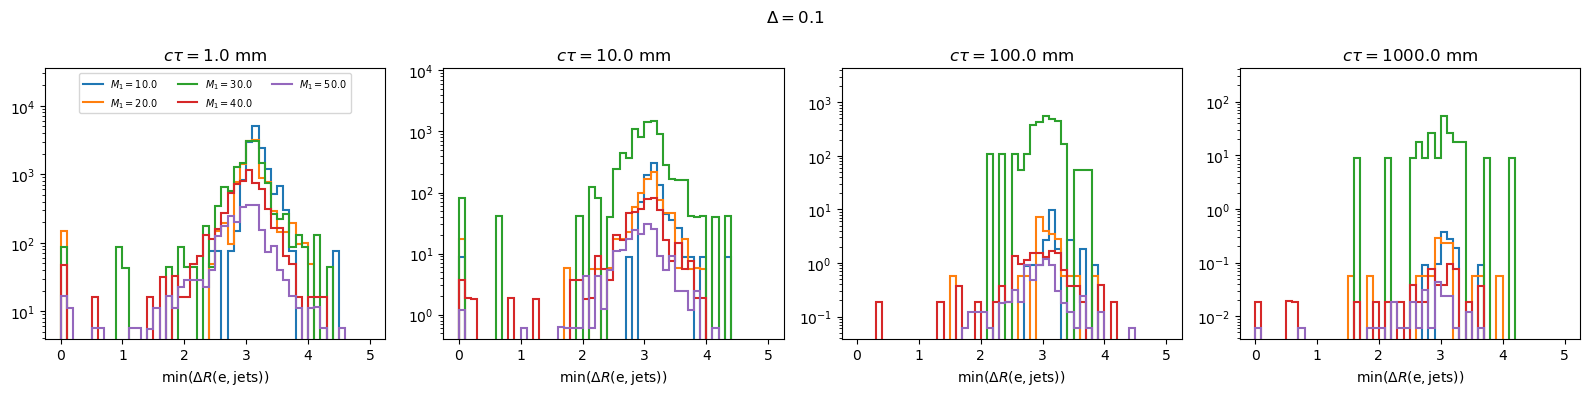

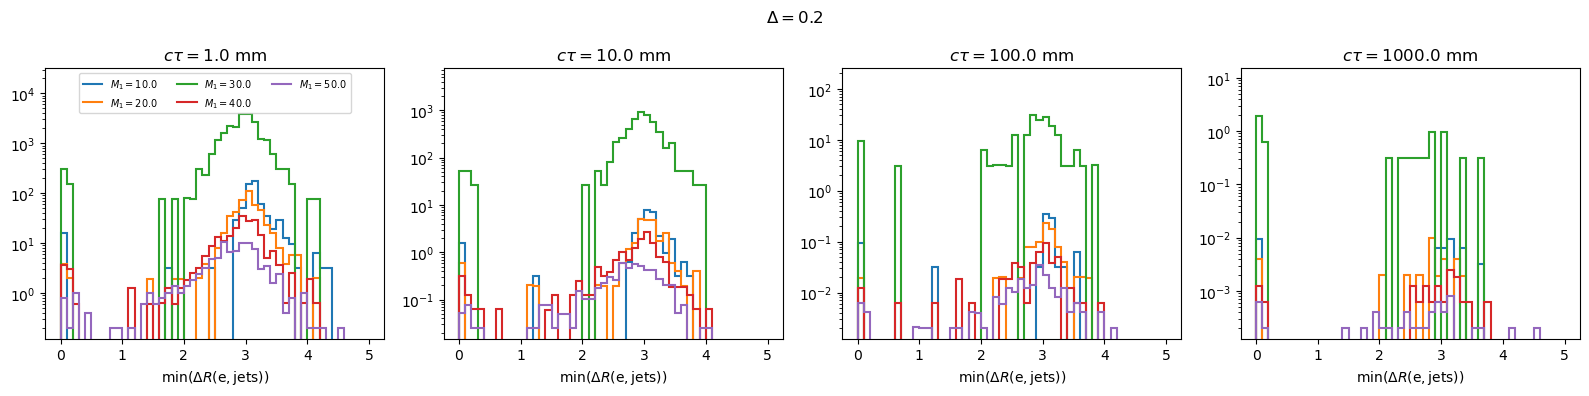

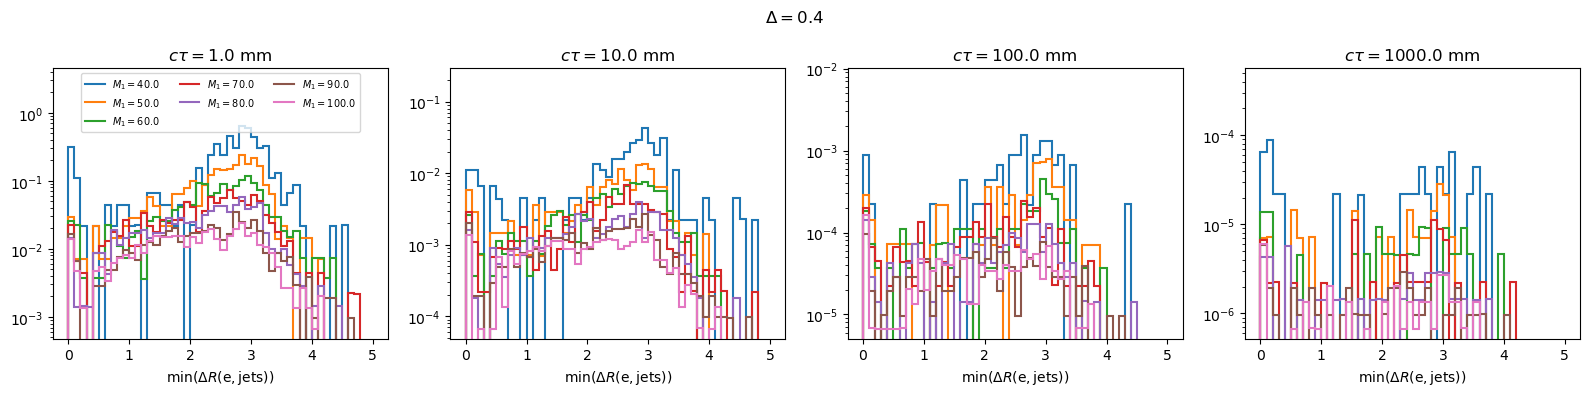

In [12]:
# electron 1 PF isolation dR < 0.3
plot("genEle_mindRjGen",None,rej=True,logy=True,rebin=1j)

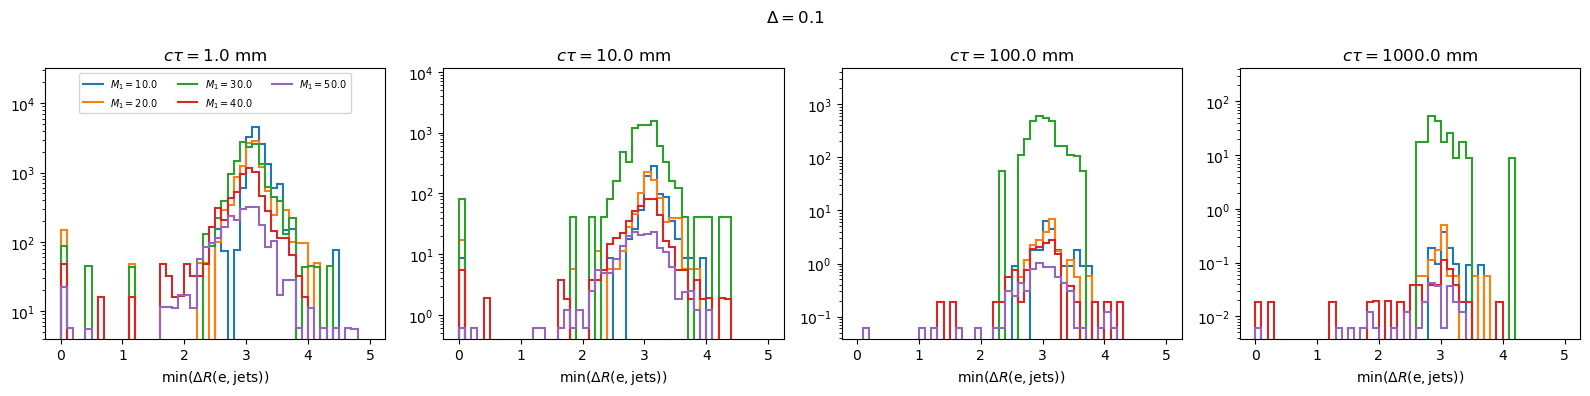

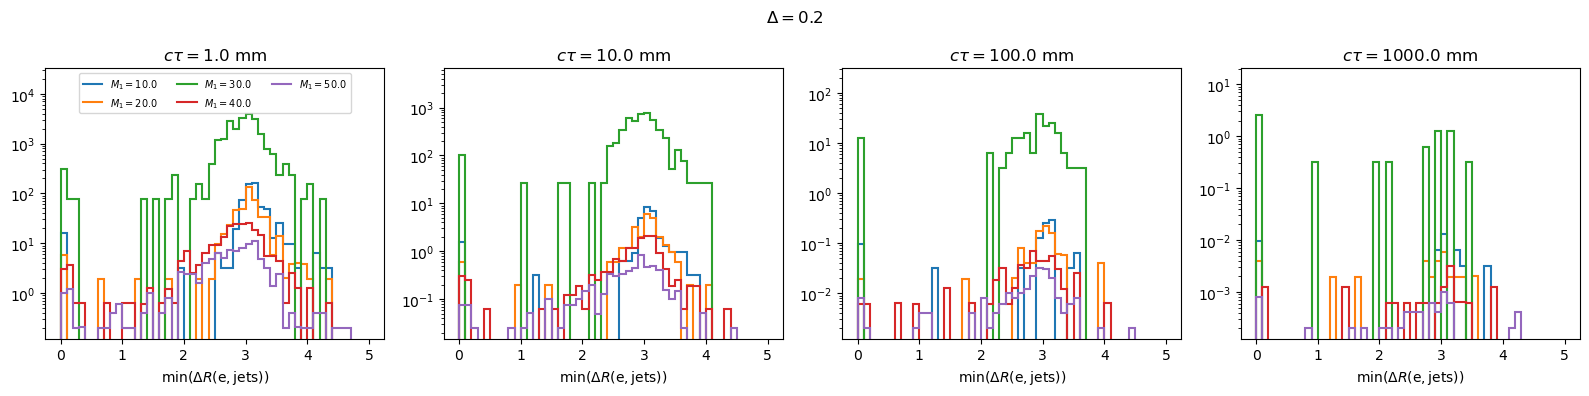

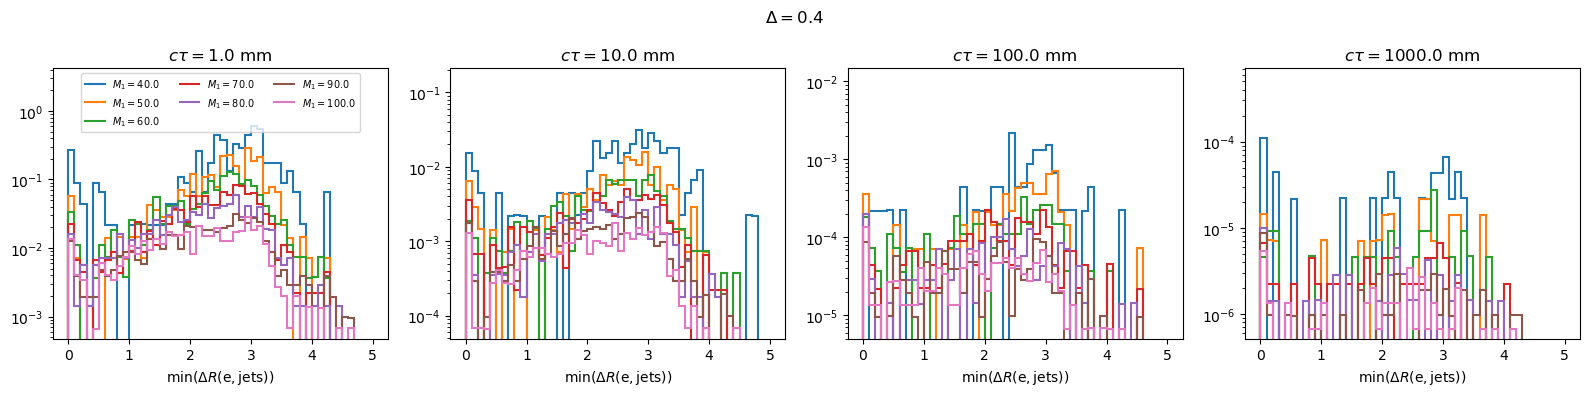

In [13]:
# electron 1 PF isolation dR < 0.3
plot("genPos_mindRjGen",None,rej=True,logy=True,rebin=1j)

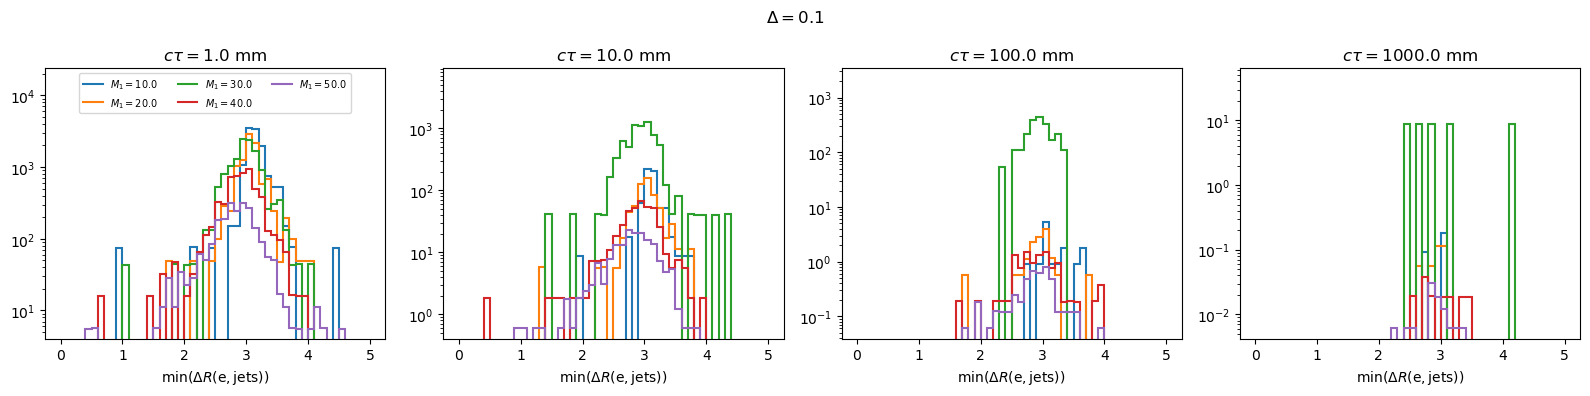

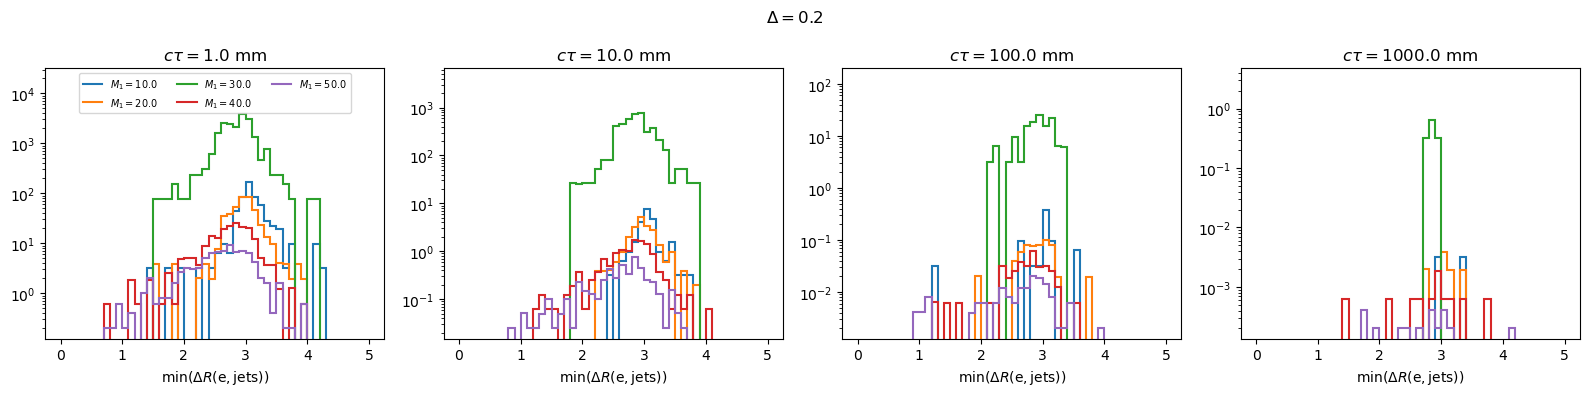

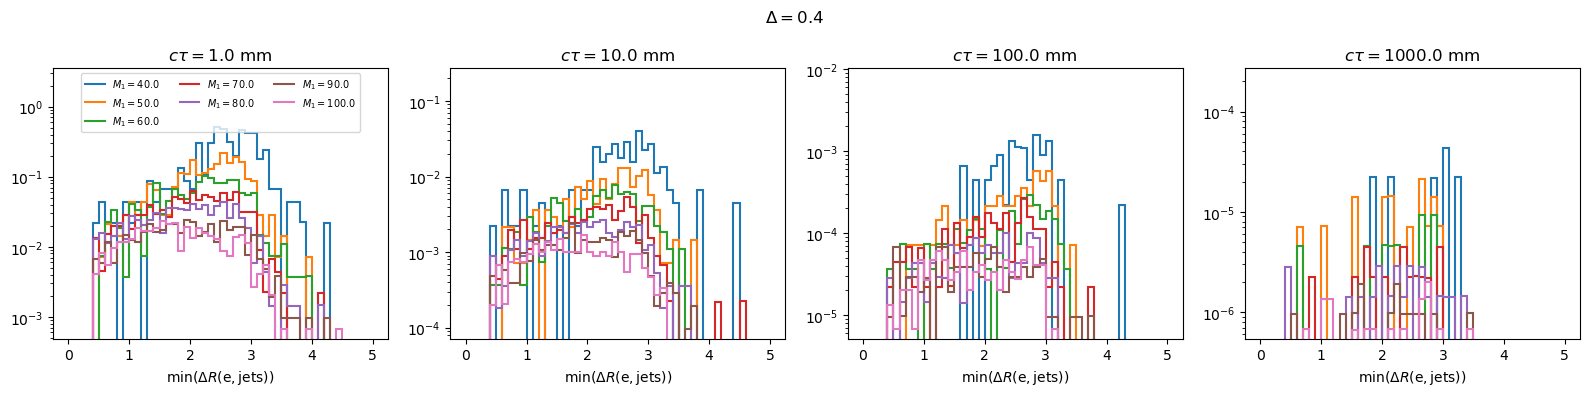

In [14]:
extra = lambda x: x[{"mtype":2}]
plot("sel_vtx_minEledRj_vs_matchType",None,extra=extra,rej=True,logy=True,rebin=1j)

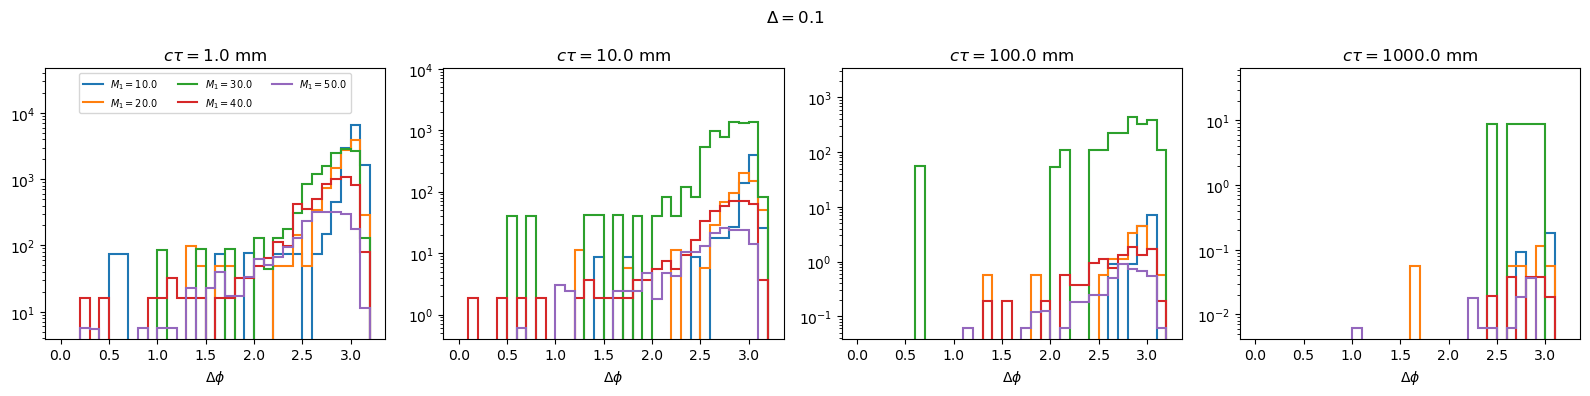

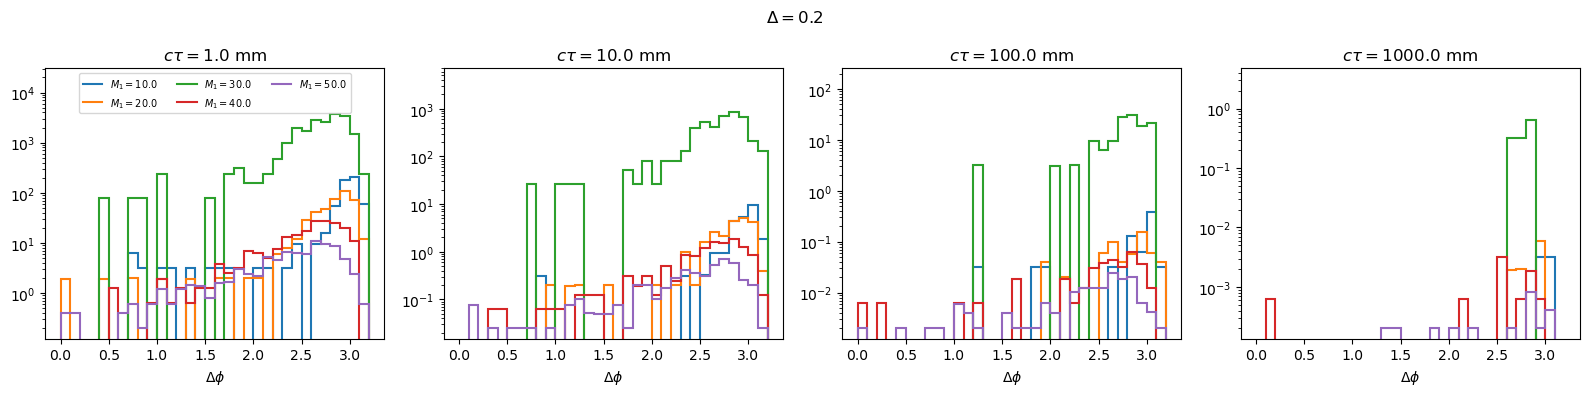

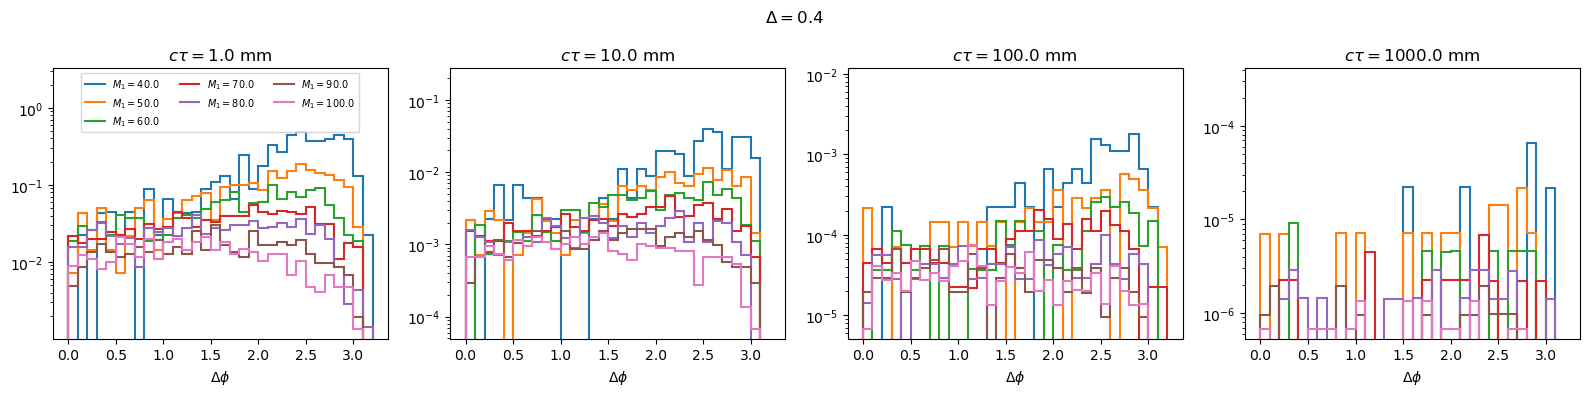

In [15]:
extra = lambda x: x[{"mtype":2}]
plot("sel_vtx_minEledPhiJ_vs_matchType",None,extra=extra,rej=True,logy=True,rebin=1j)

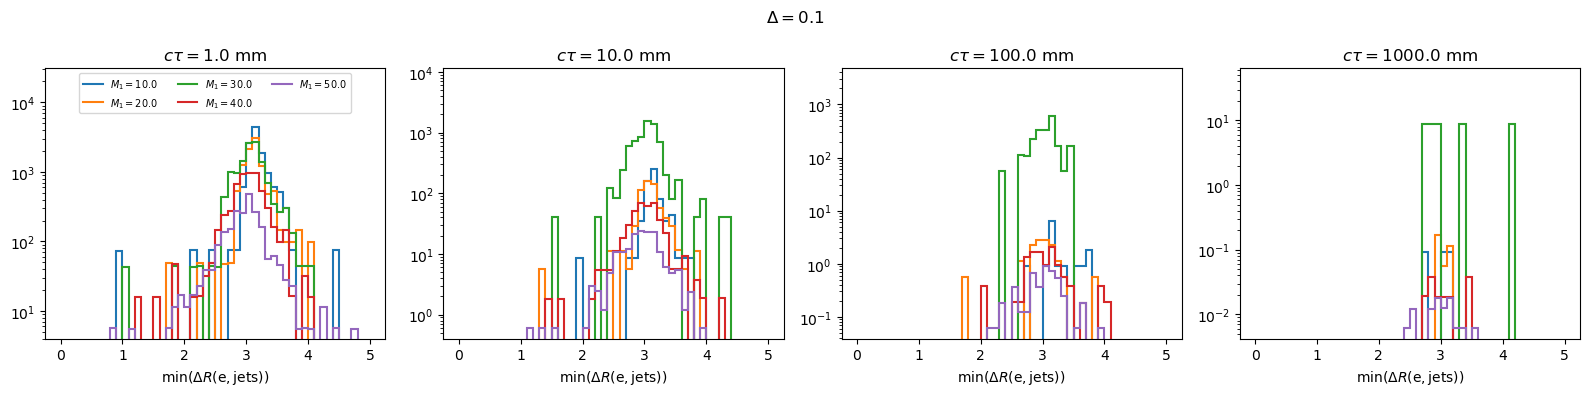

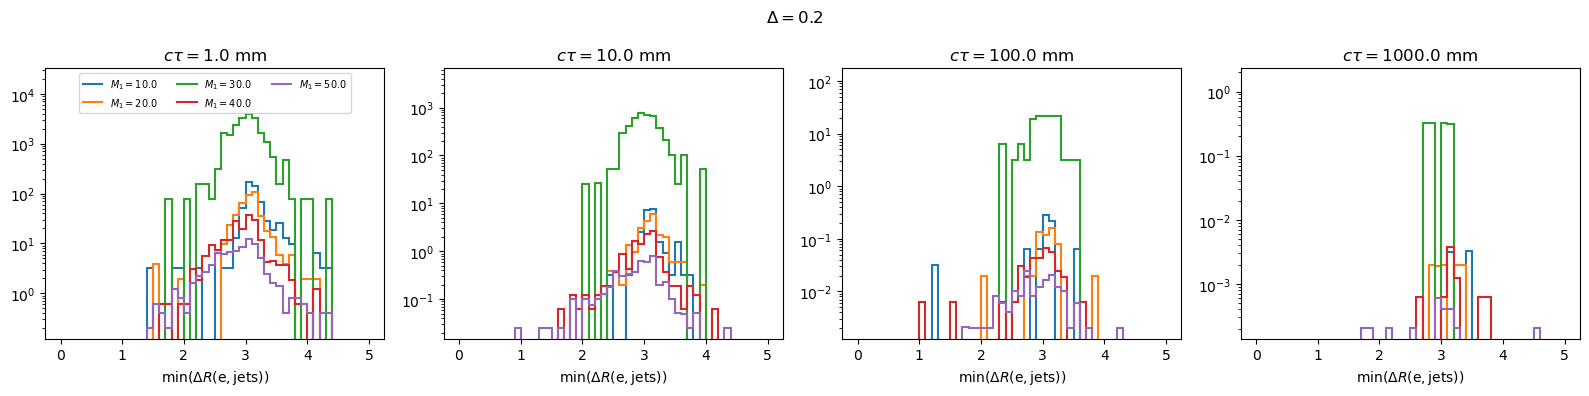

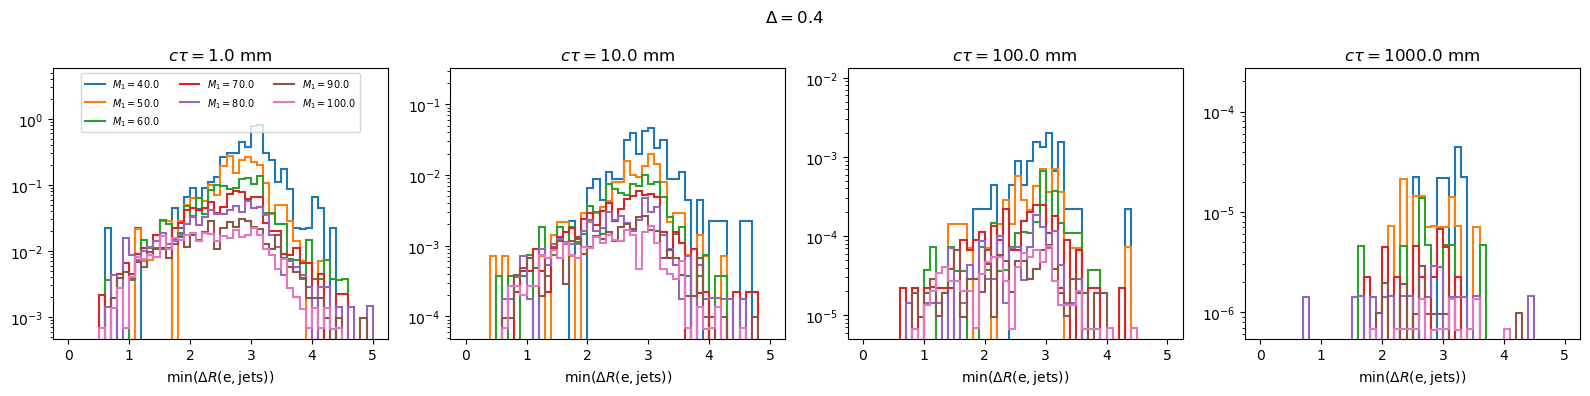

In [16]:
extra = lambda x: x[{"mtype":2}]
plot("sel_vtx_mindRj_vs_matchType",None,extra=extra,rej=True,logy=True,rebin=1j)

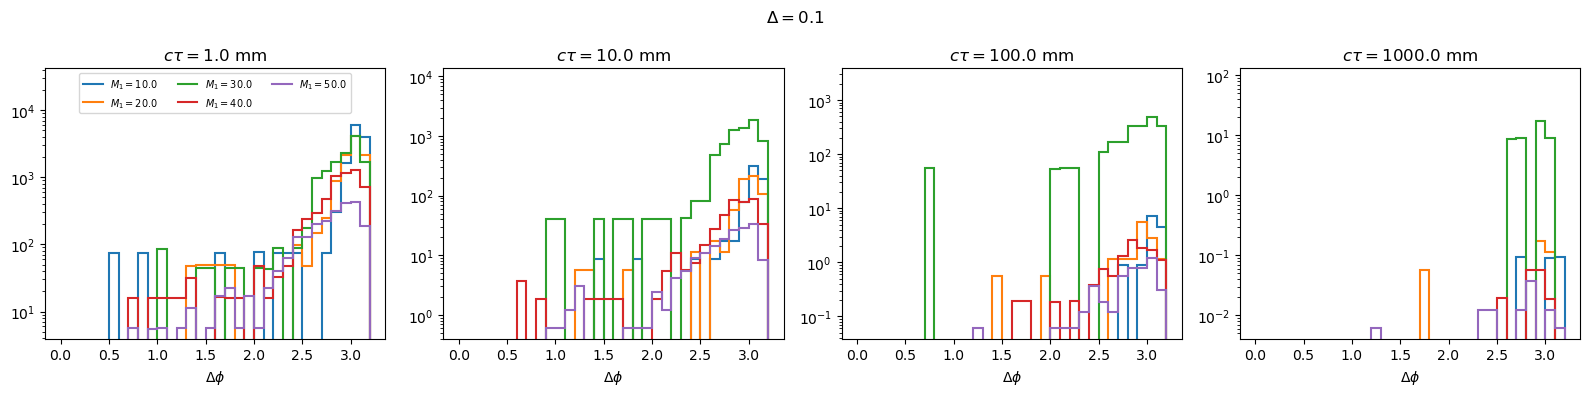

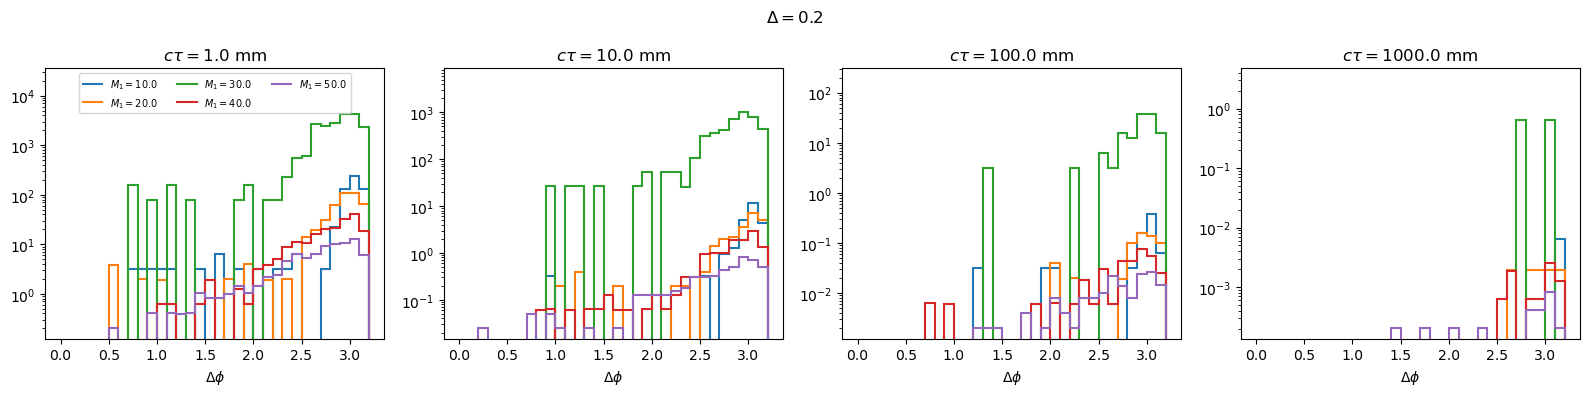

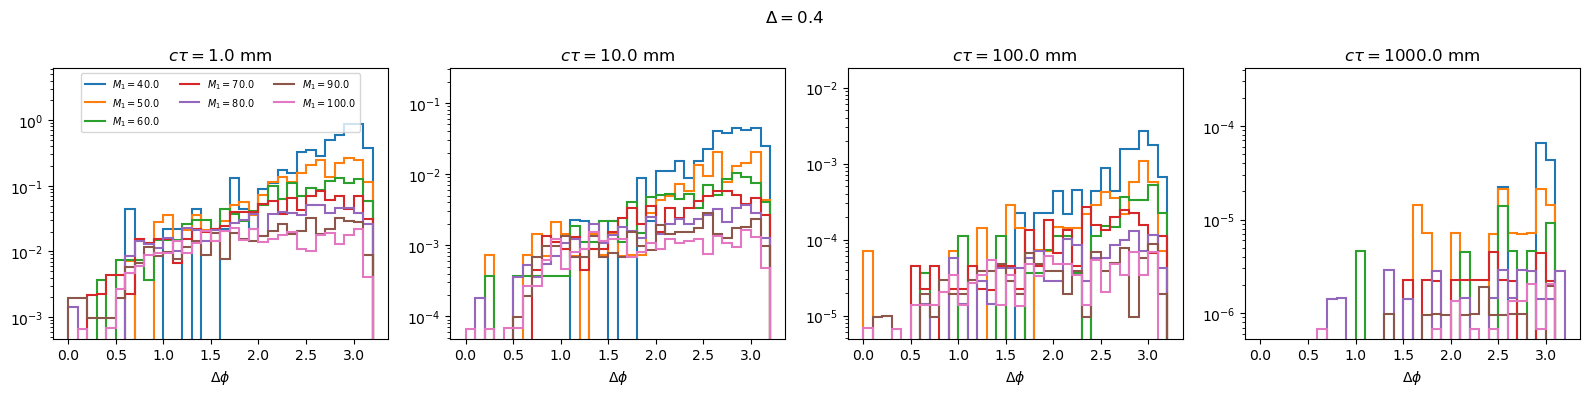

In [17]:
extra = lambda x: x[{"mtype":2}]
plot("sel_vtx_mindPhiJ_vs_matchType",None,extra=extra,rej=True,logy=True,rebin=1j)

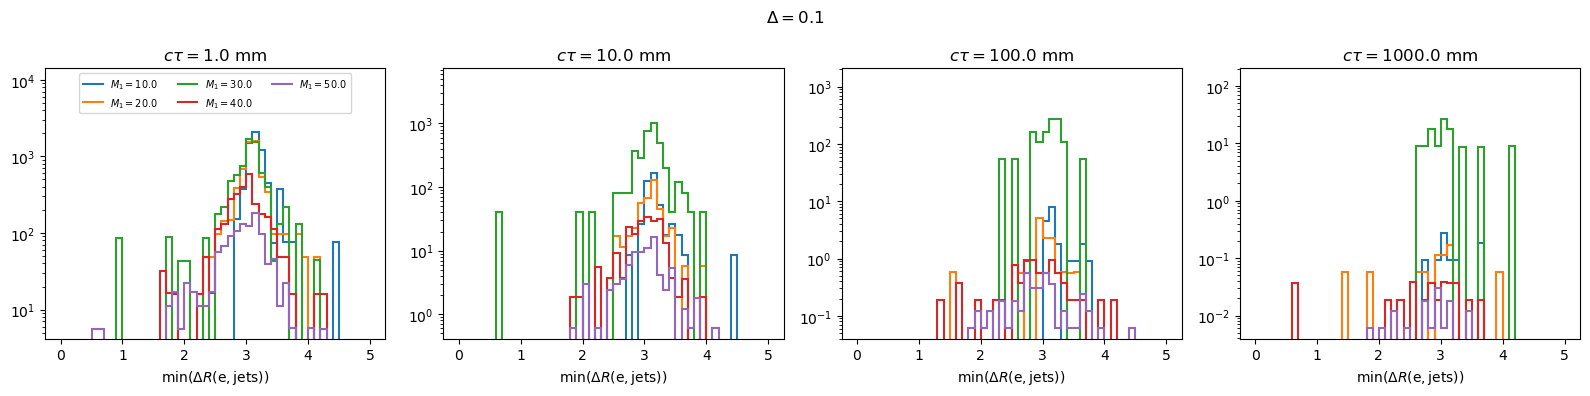

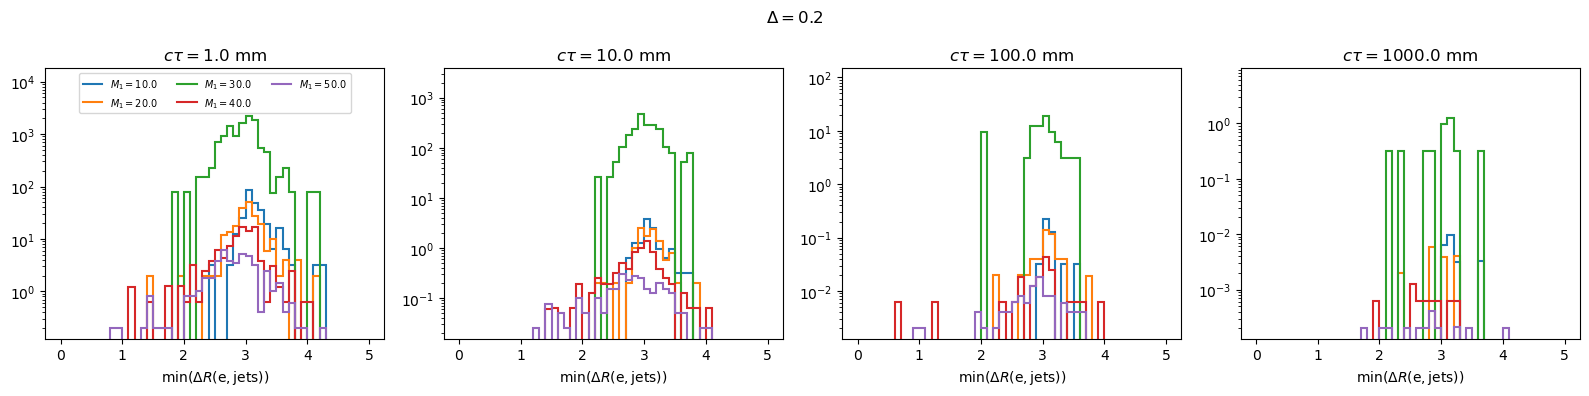

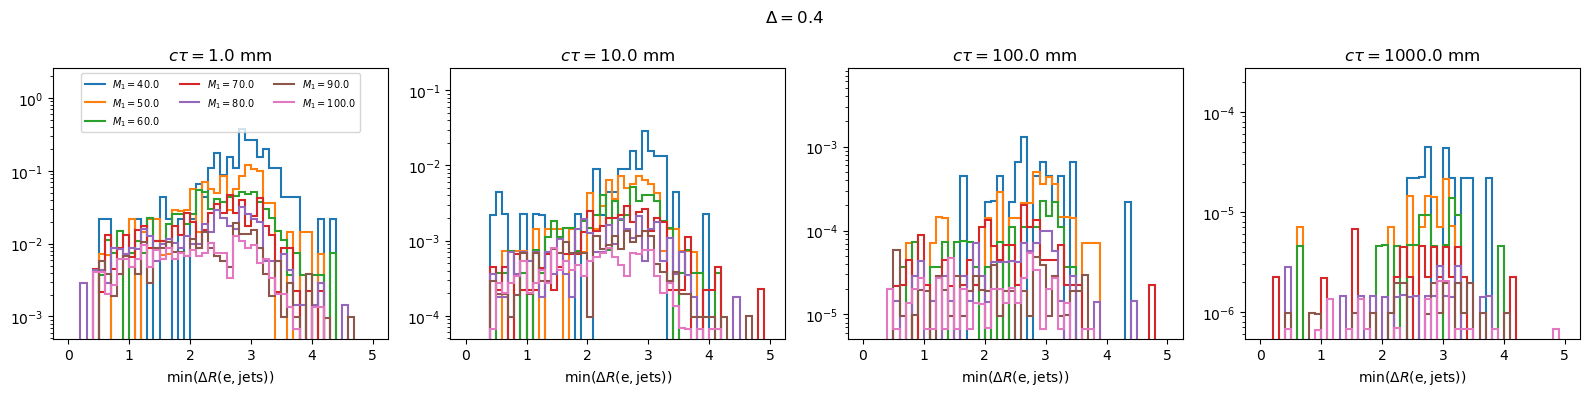

In [53]:
plot("genEle_mindRj",None,rej=True,logy=True,rebin=1j)

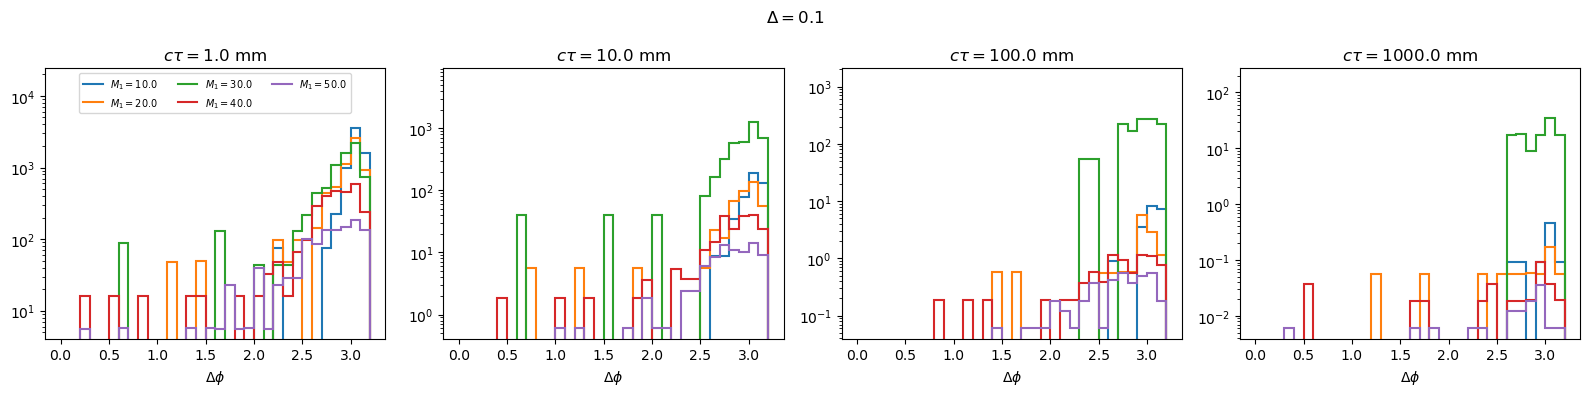

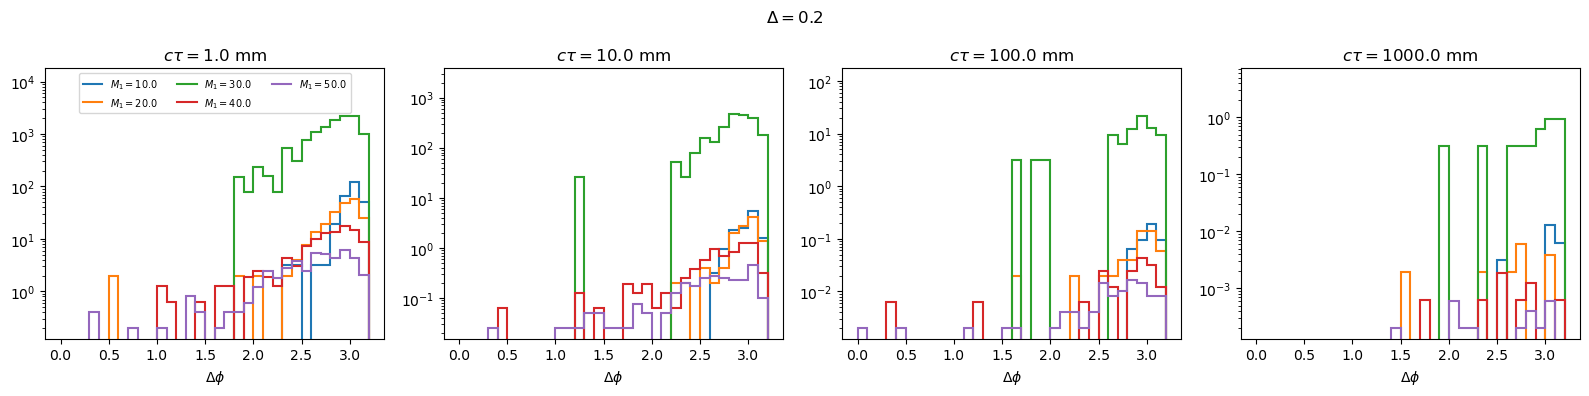

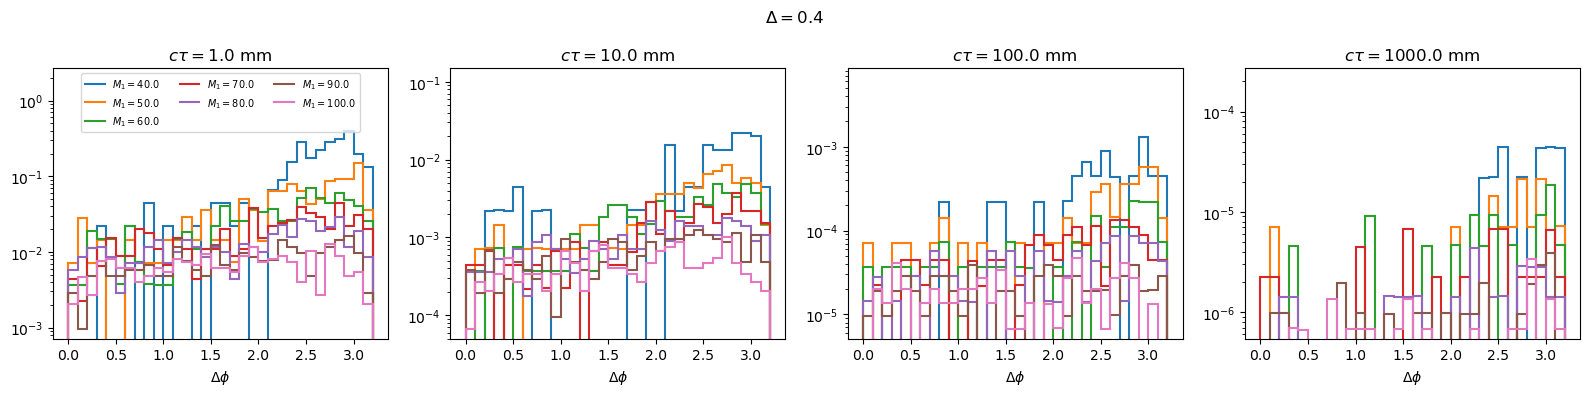

In [54]:
plot("genEle_mindPhiJ",None,rej=True,logy=True,rebin=1j)

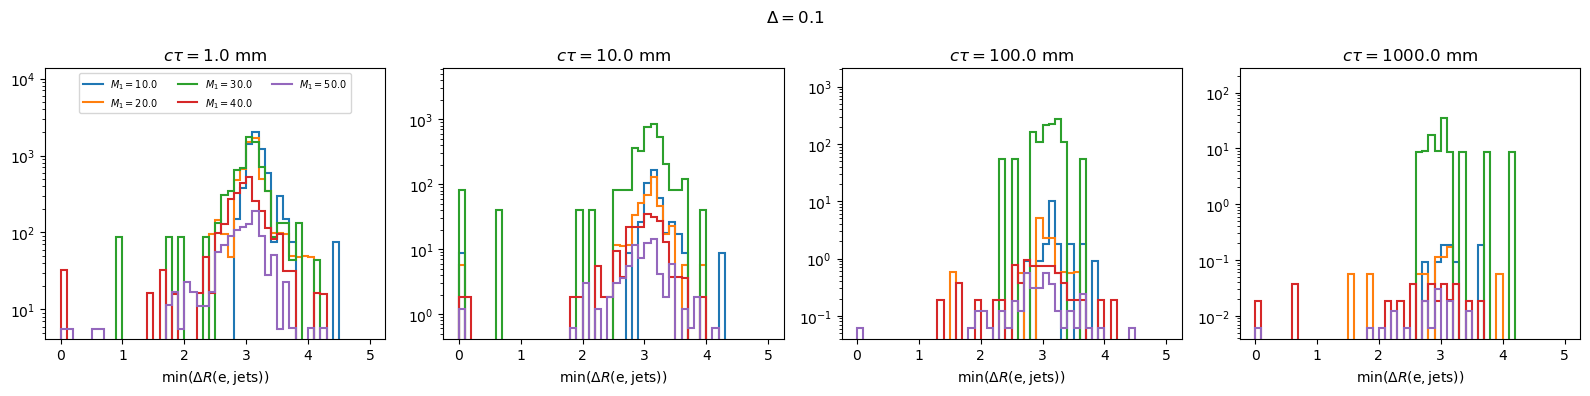

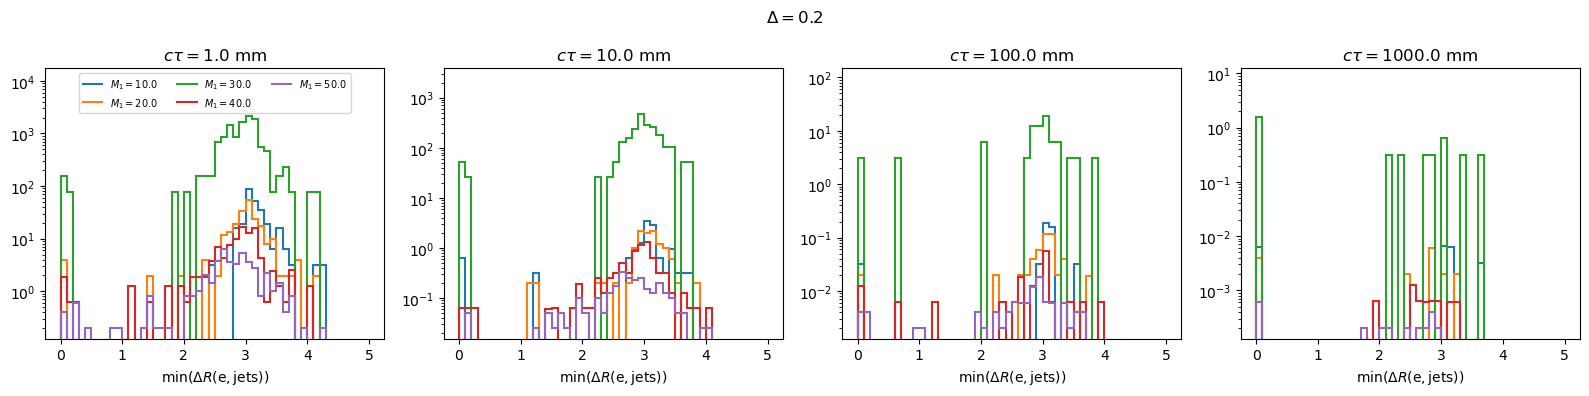

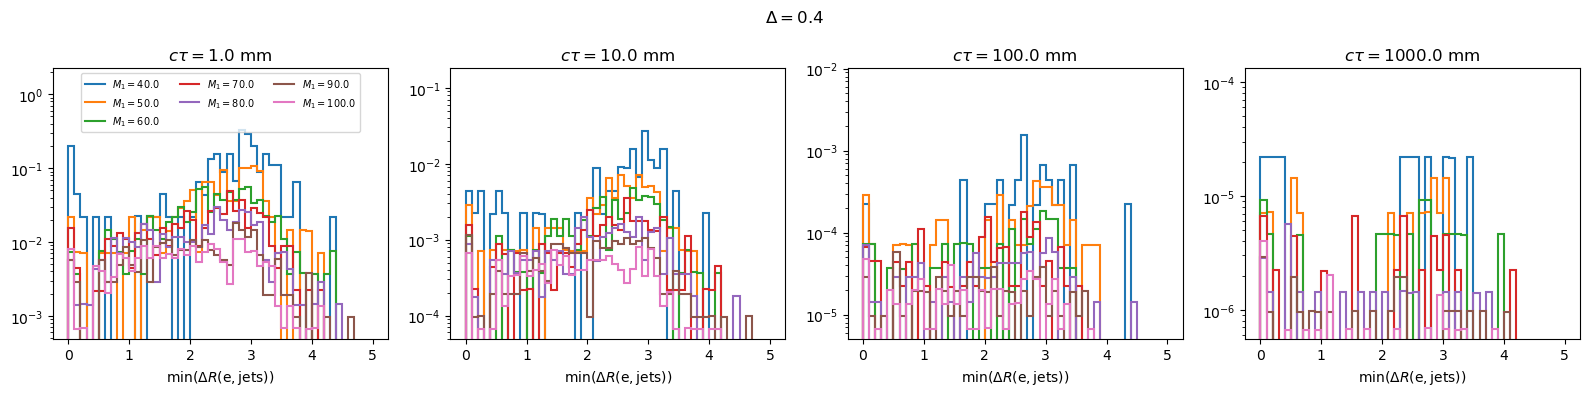

In [55]:
plot("genEle_mindRjGen",None,rej=True,logy=True,rebin=1j)

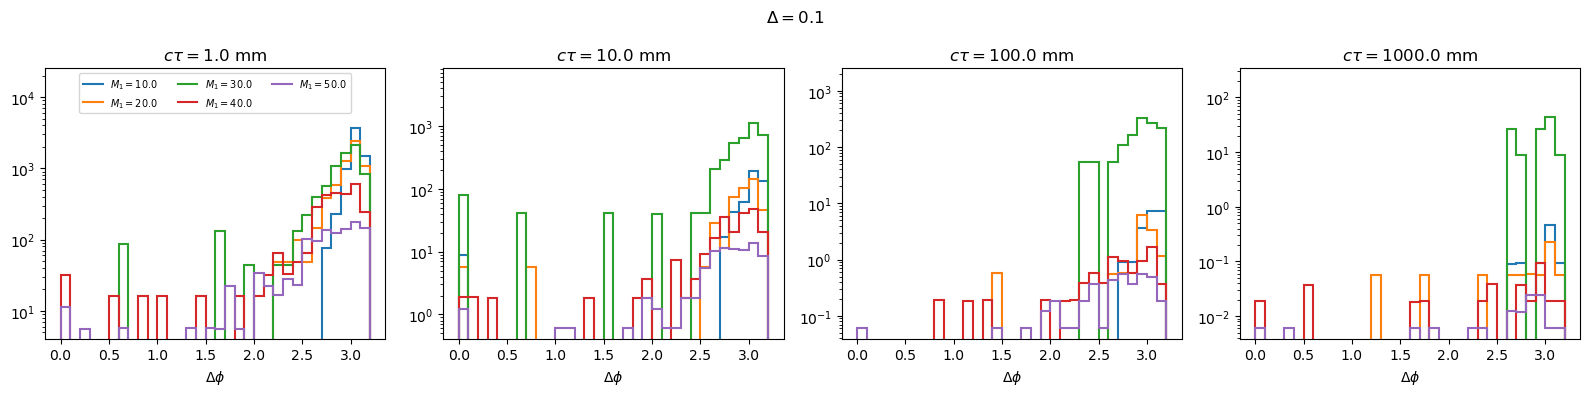

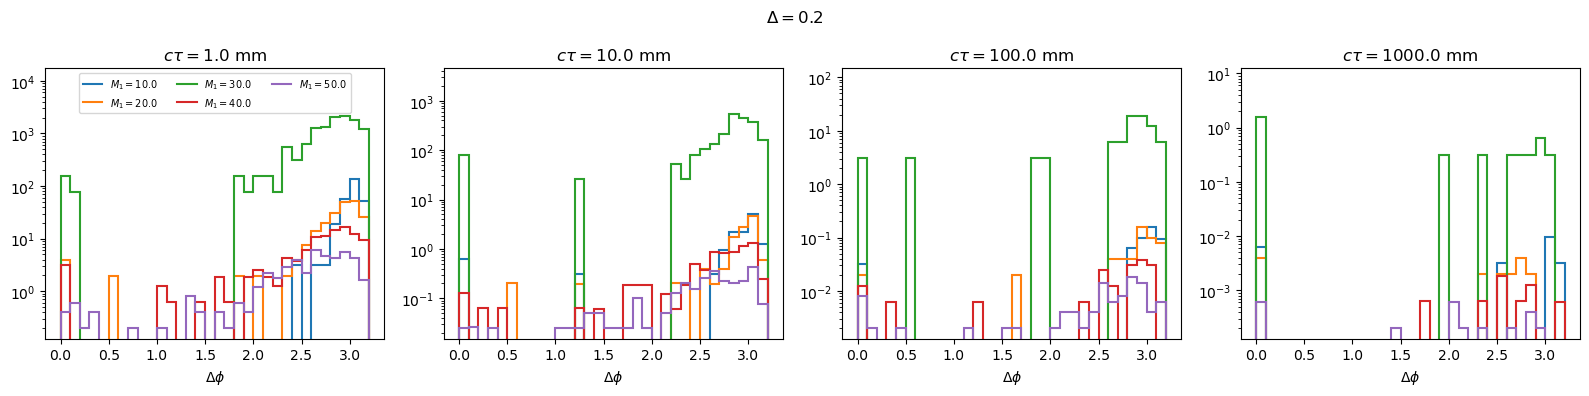

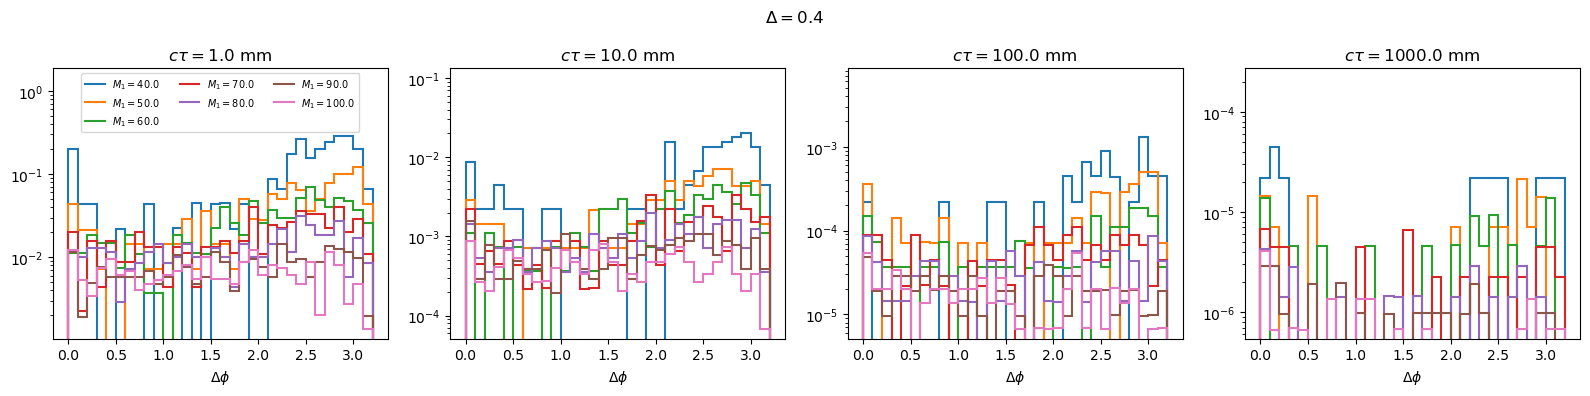

In [56]:
plot("genEle_mindPhiJGen",None,rej=True,logy=True,rebin=1j)

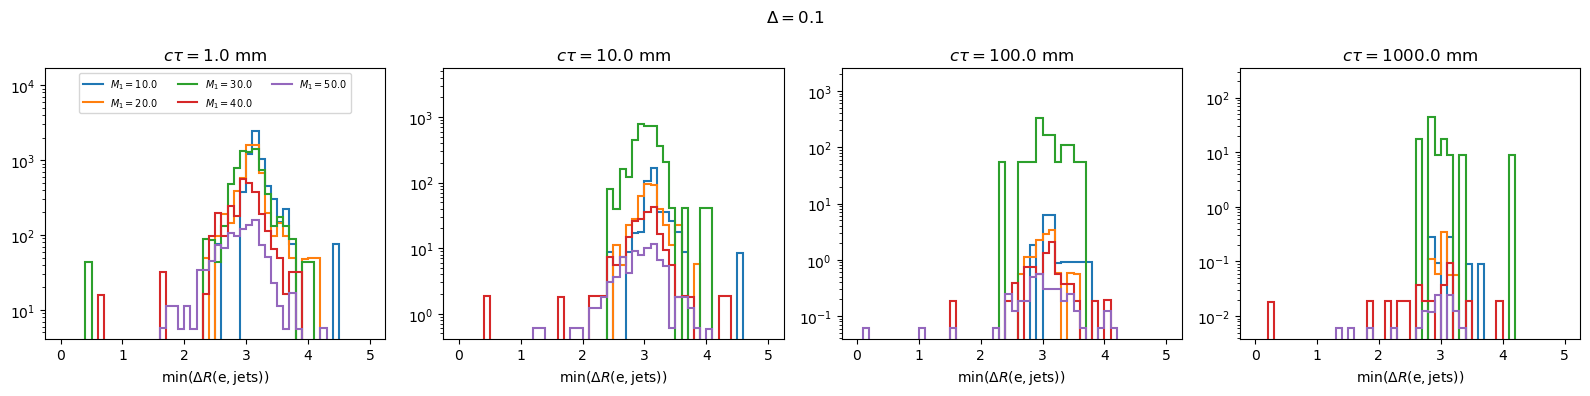

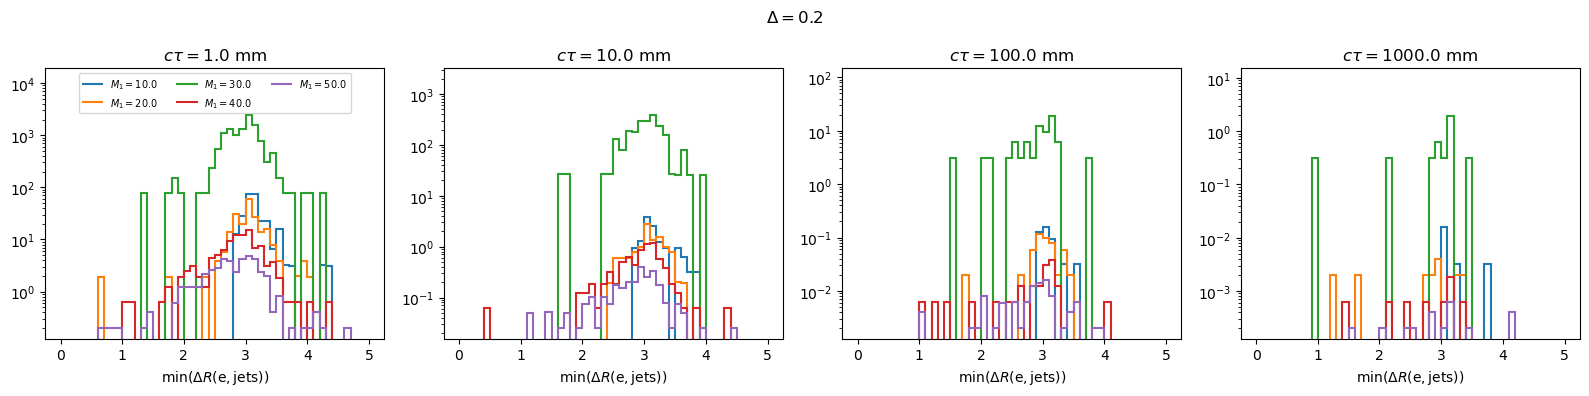

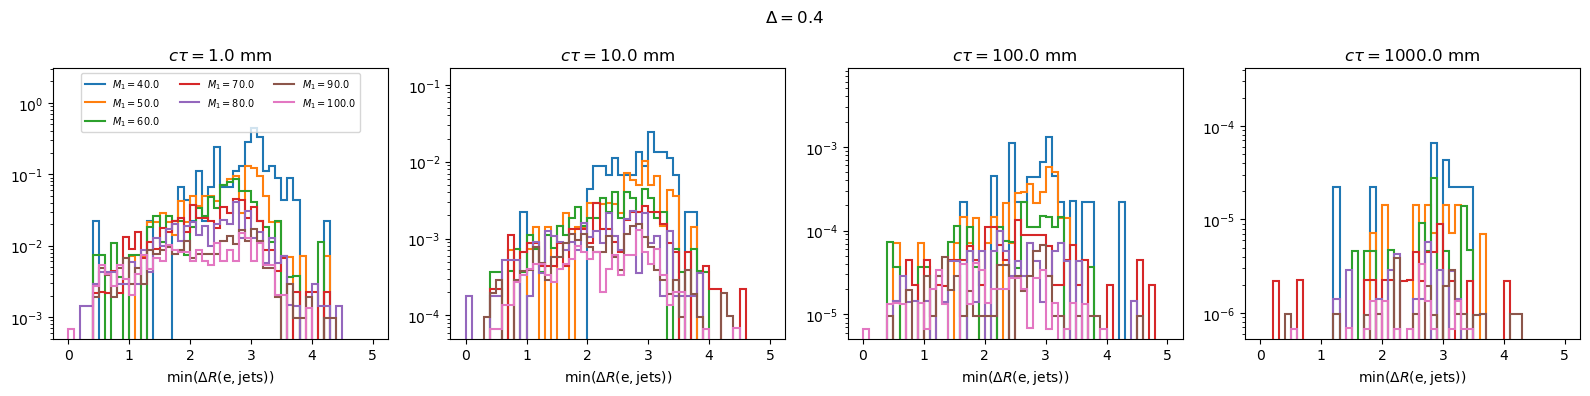

In [57]:
plot("genPos_mindRj",None,rej=True,logy=True,rebin=1j)

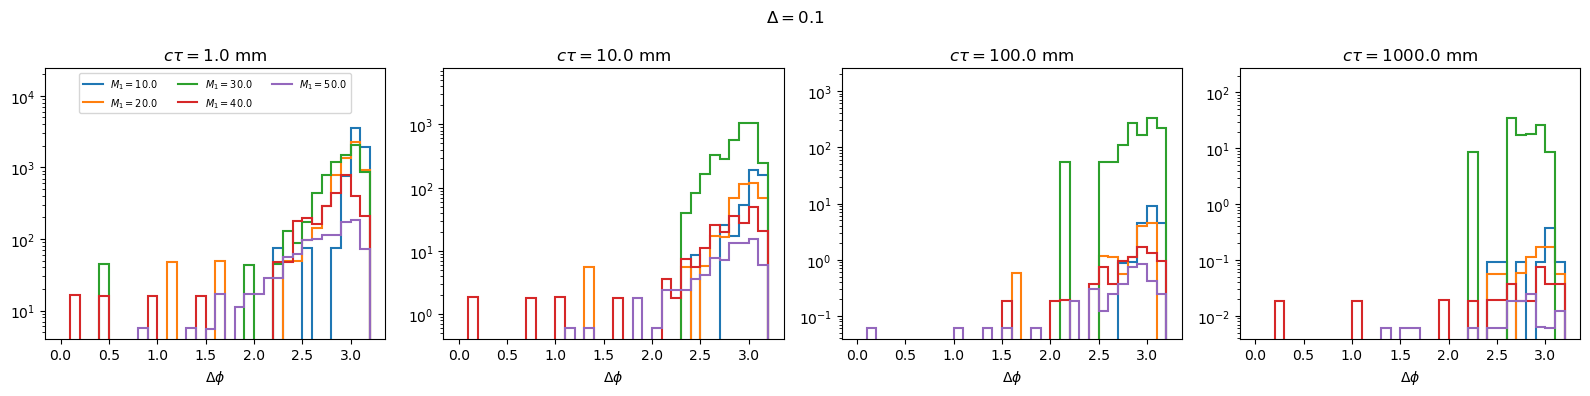

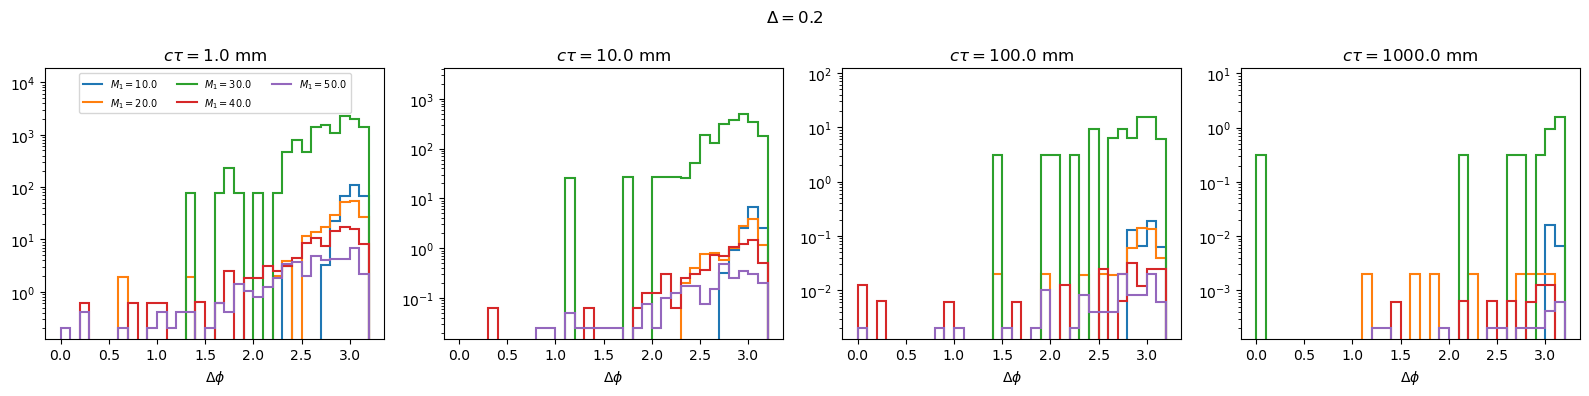

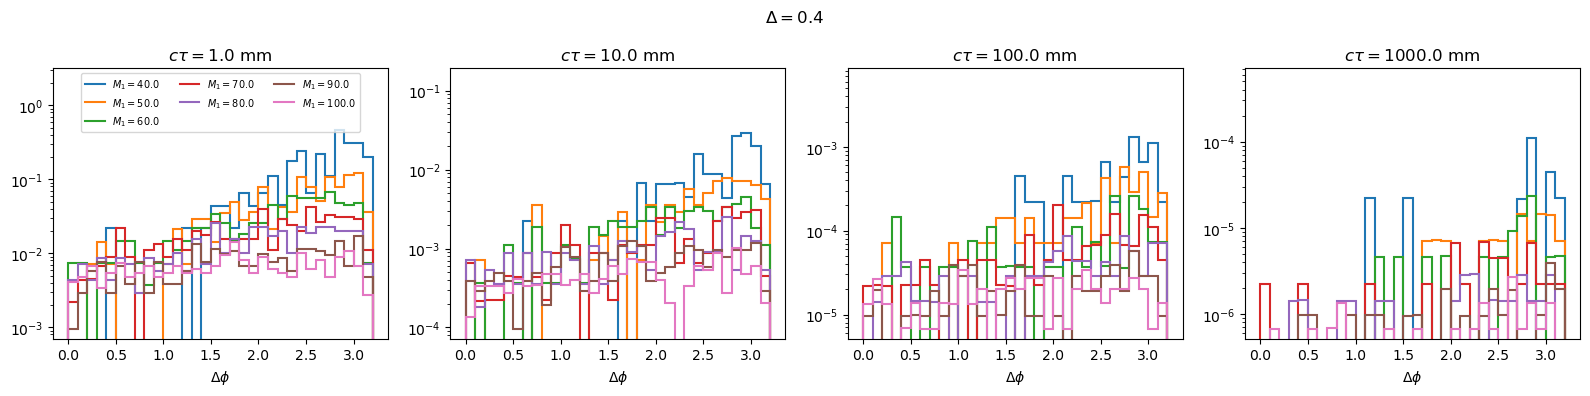

In [58]:
plot("genPos_mindPhiJ",None,rej=True,logy=True,rebin=1j)

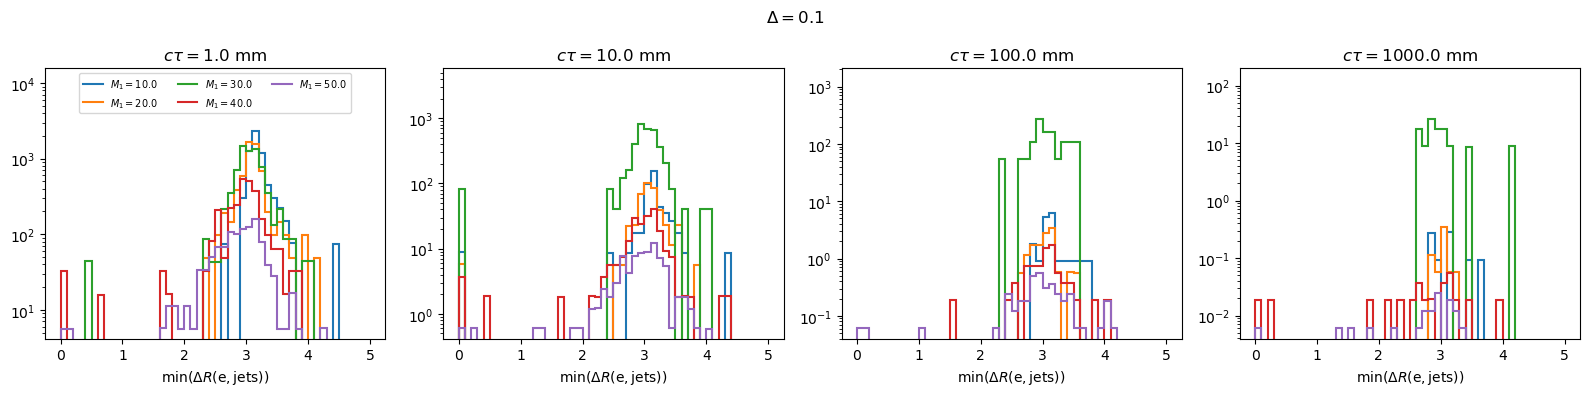

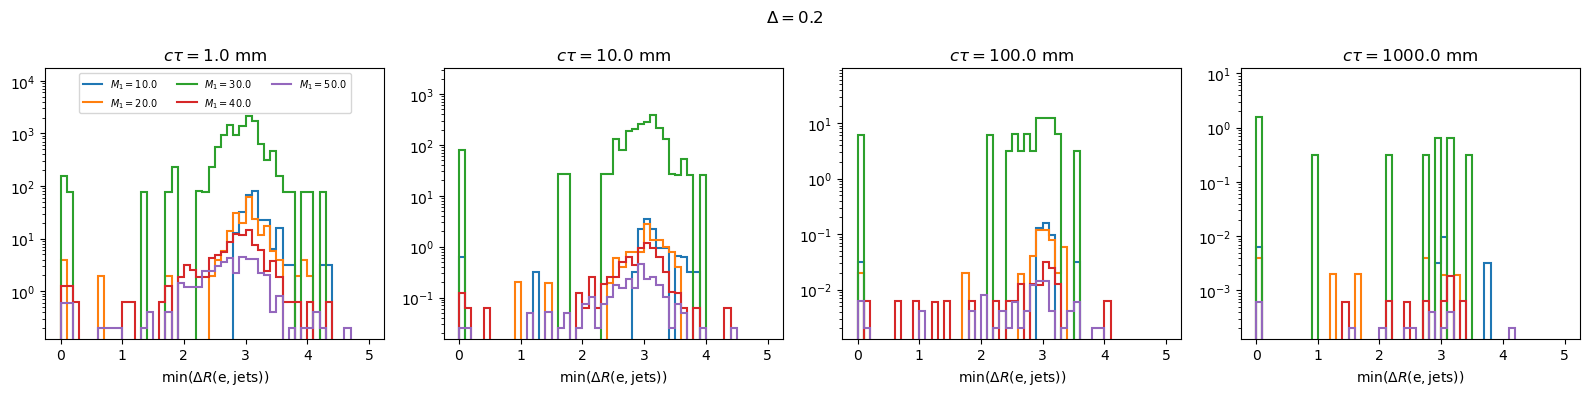

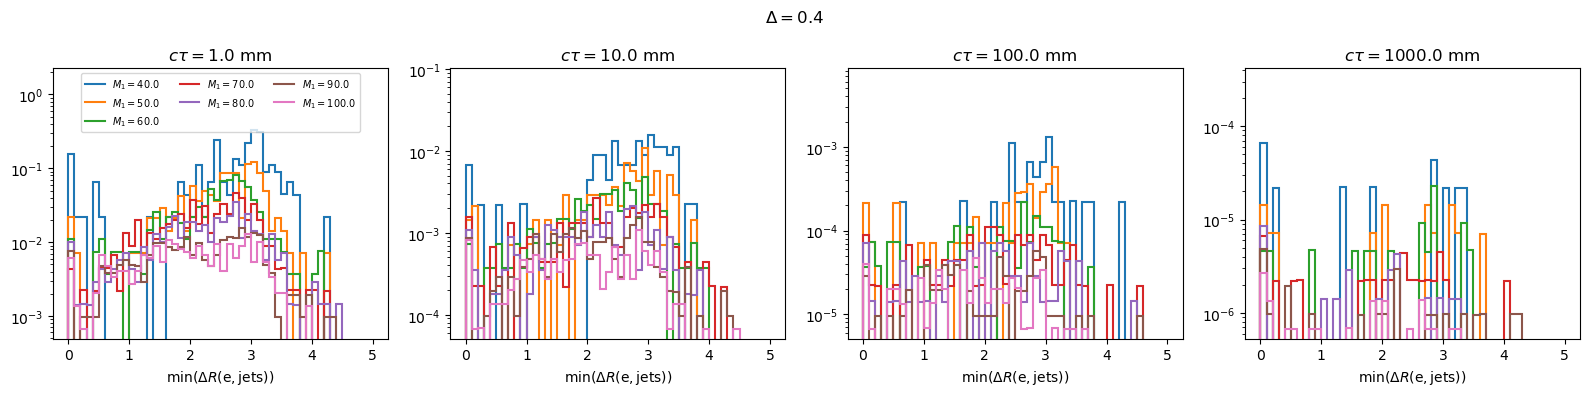

In [59]:
plot("genPos_mindRjGen",None,rej=True,logy=True,rebin=1j)

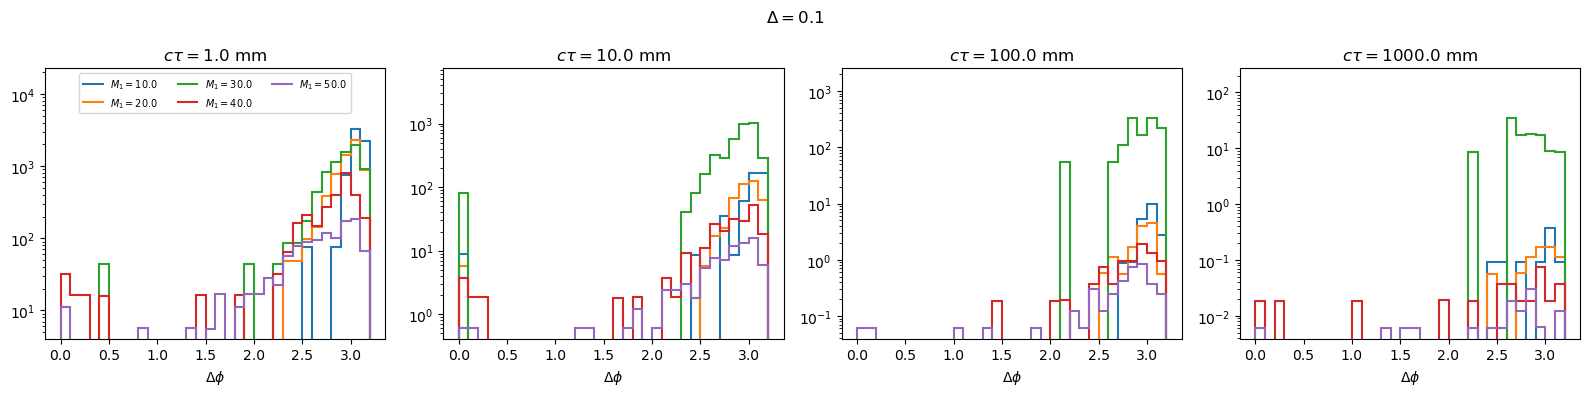

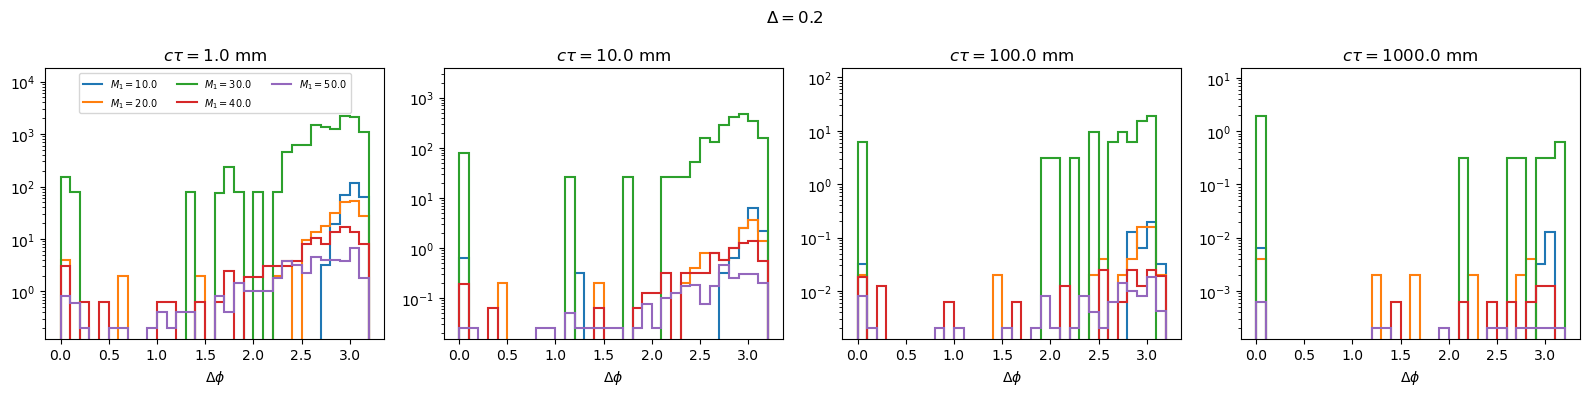

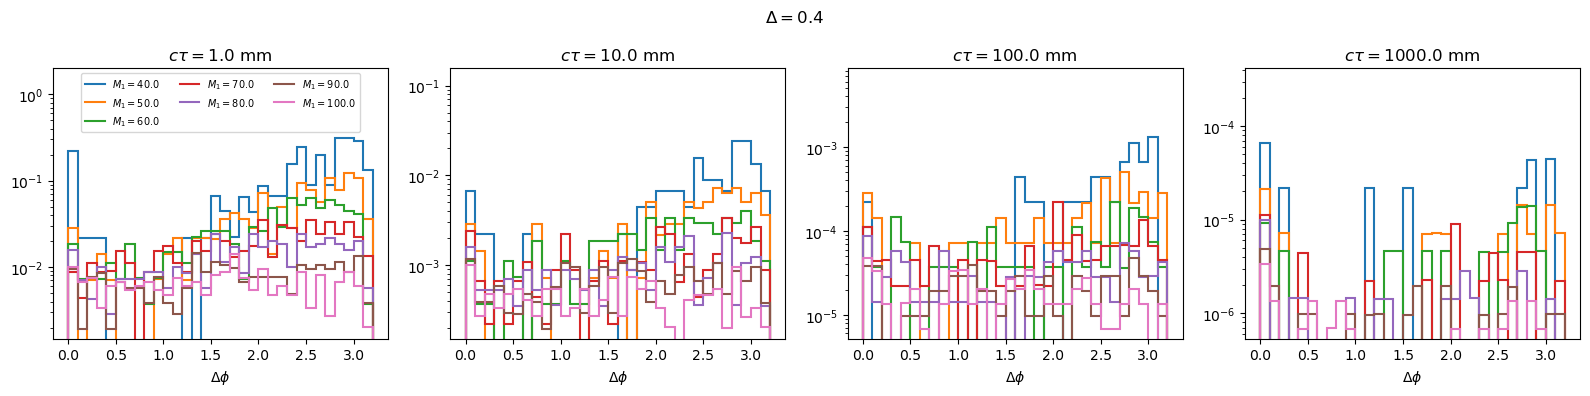

In [60]:
plot("genPos_mindPhiJGen",None,rej=True,logy=True,rebin=1j)

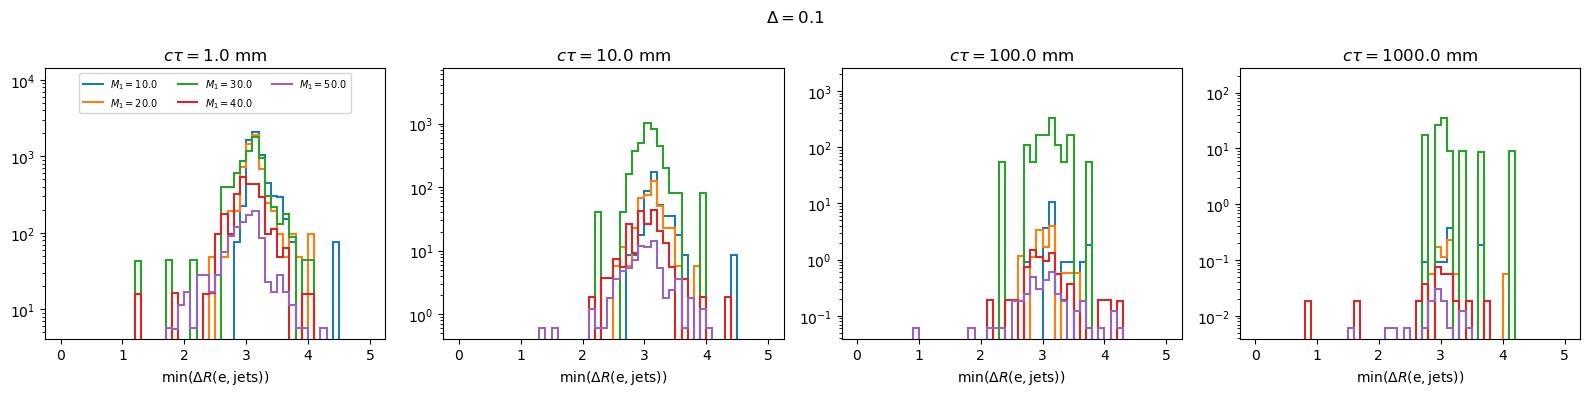

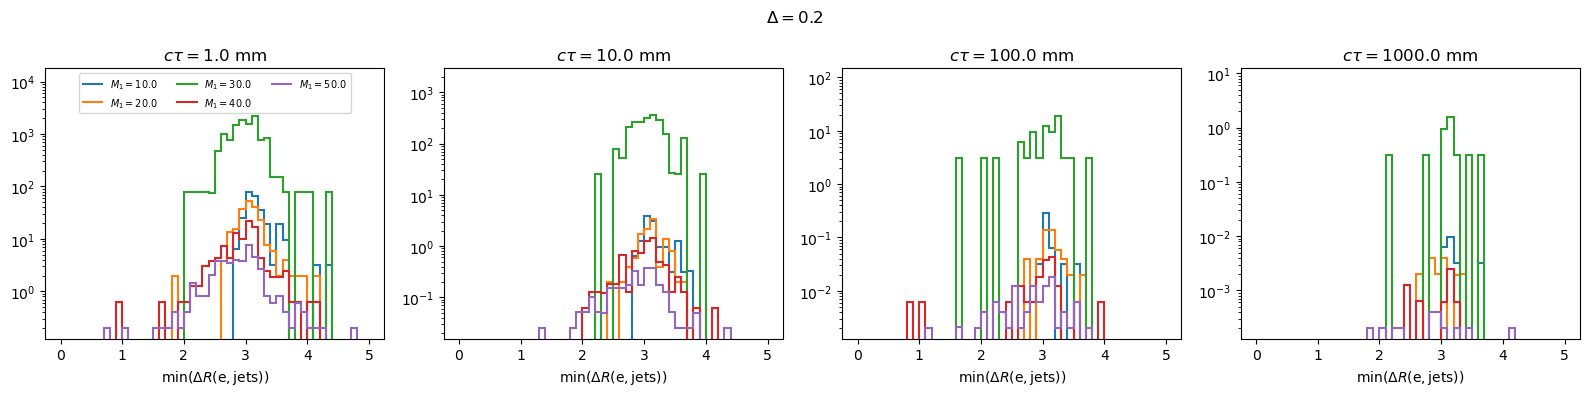

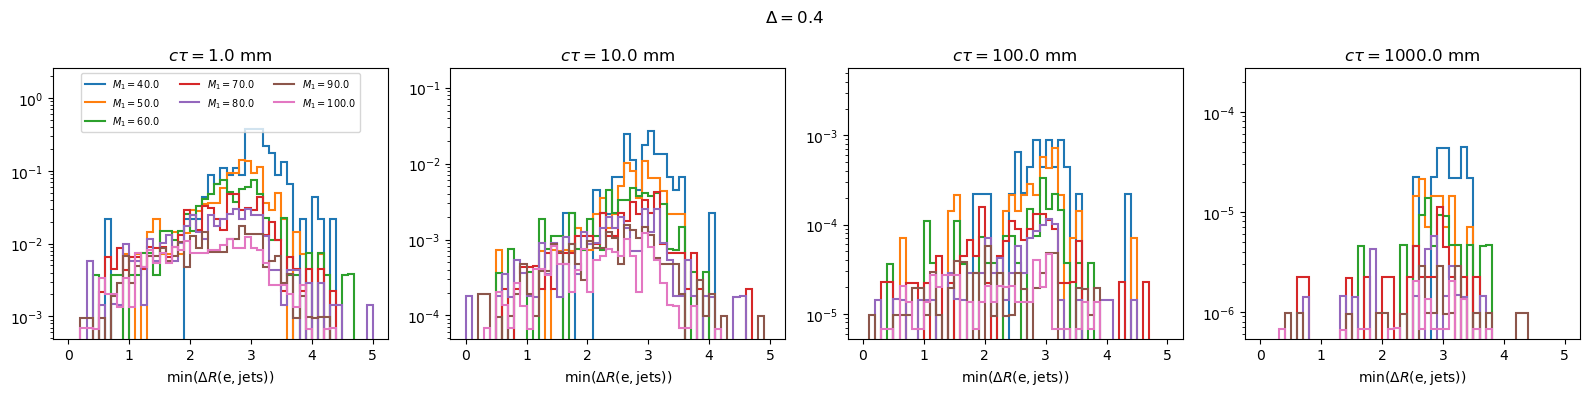

In [61]:
plot("genEE_mindRj",None,rej=True,logy=True,rebin=1j)

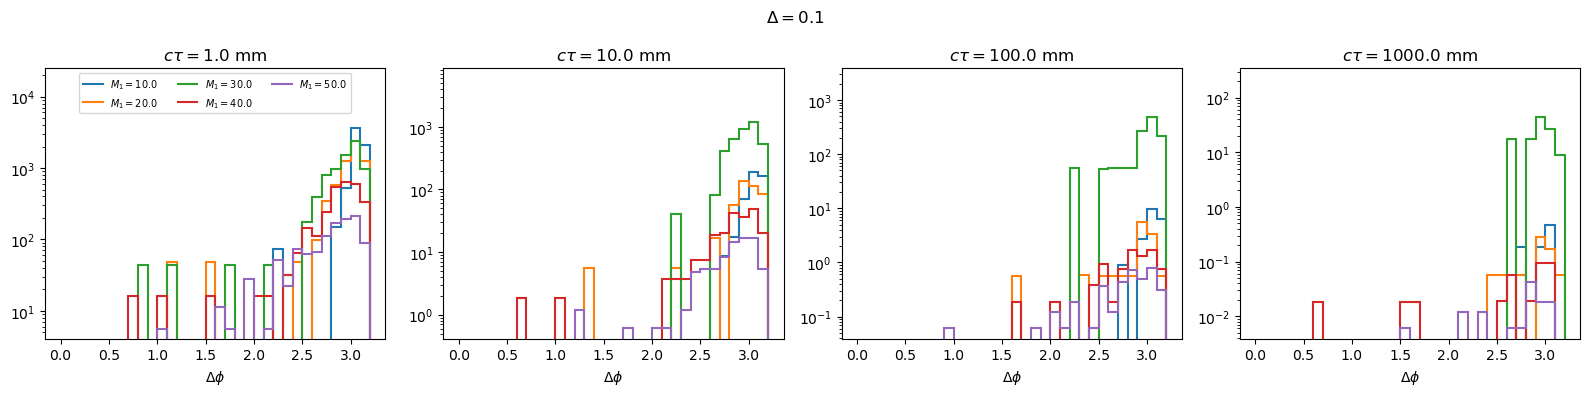

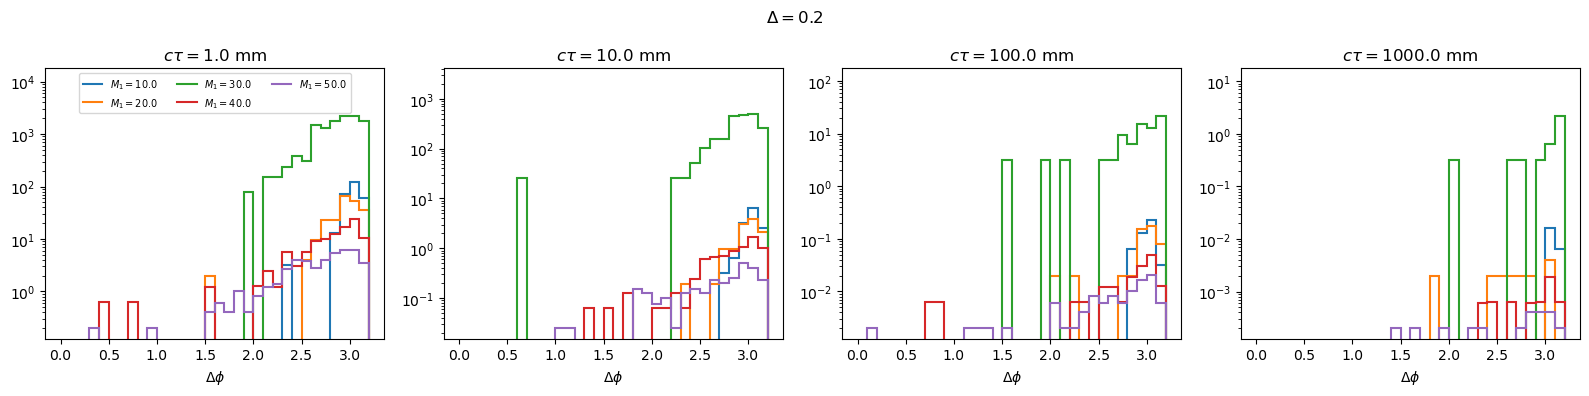

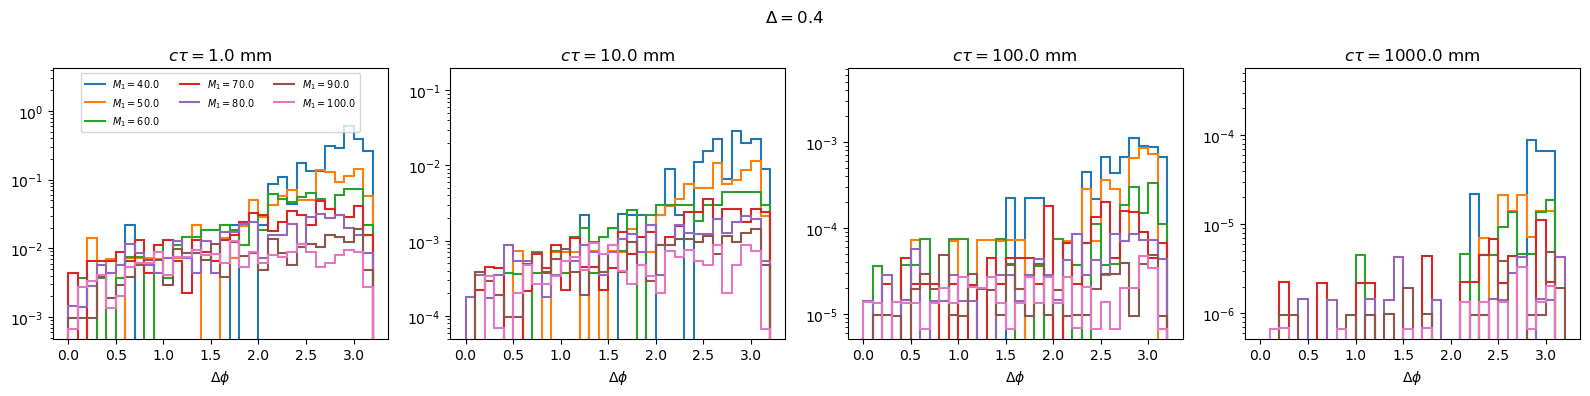

In [62]:
plot("genEE_mindPhiJ",None,rej=True,logy=True,rebin=1j)

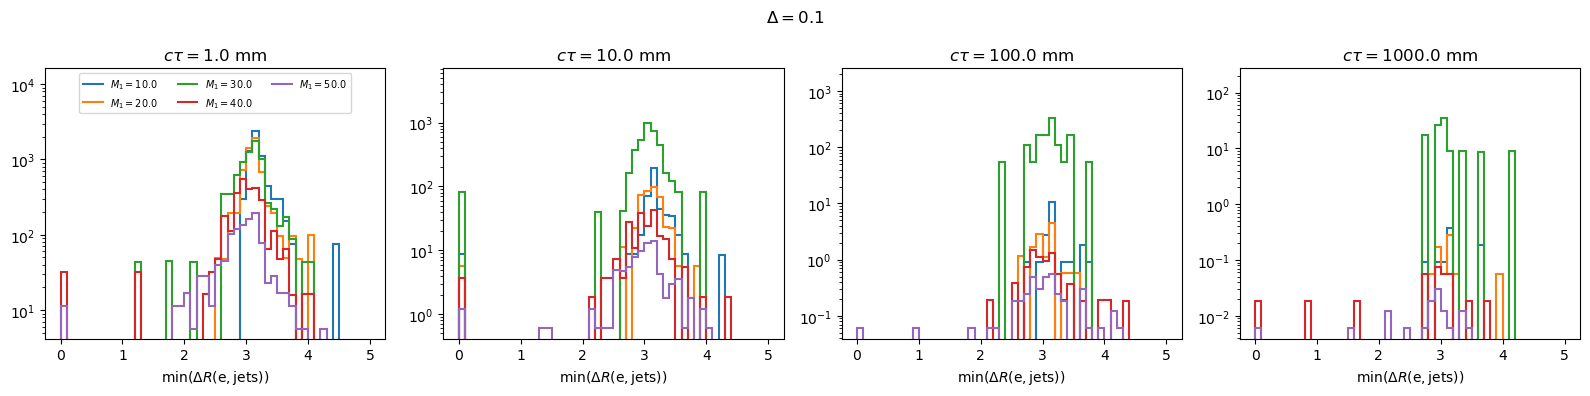

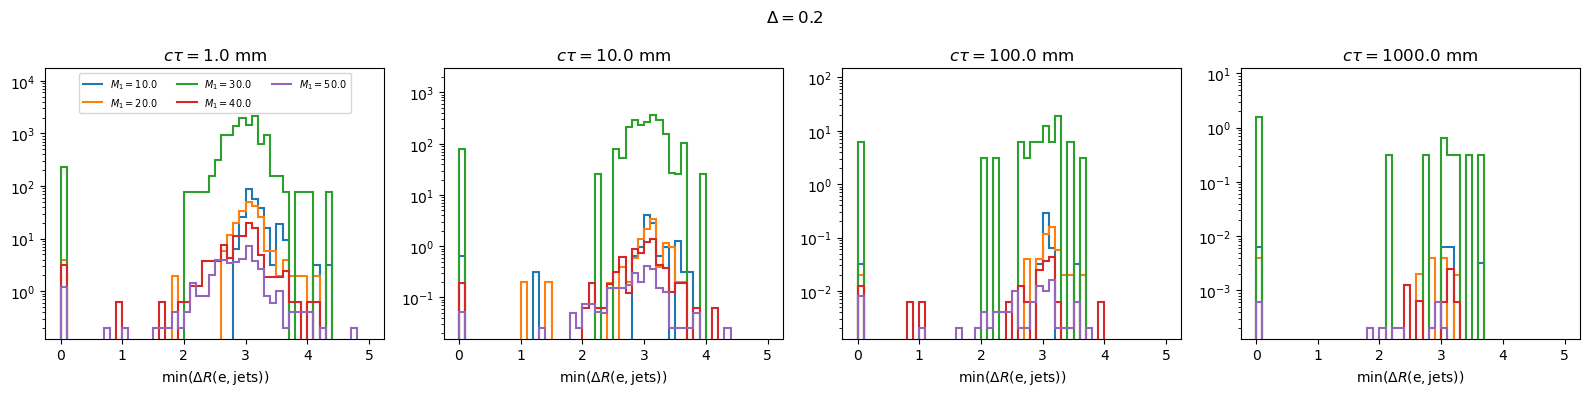

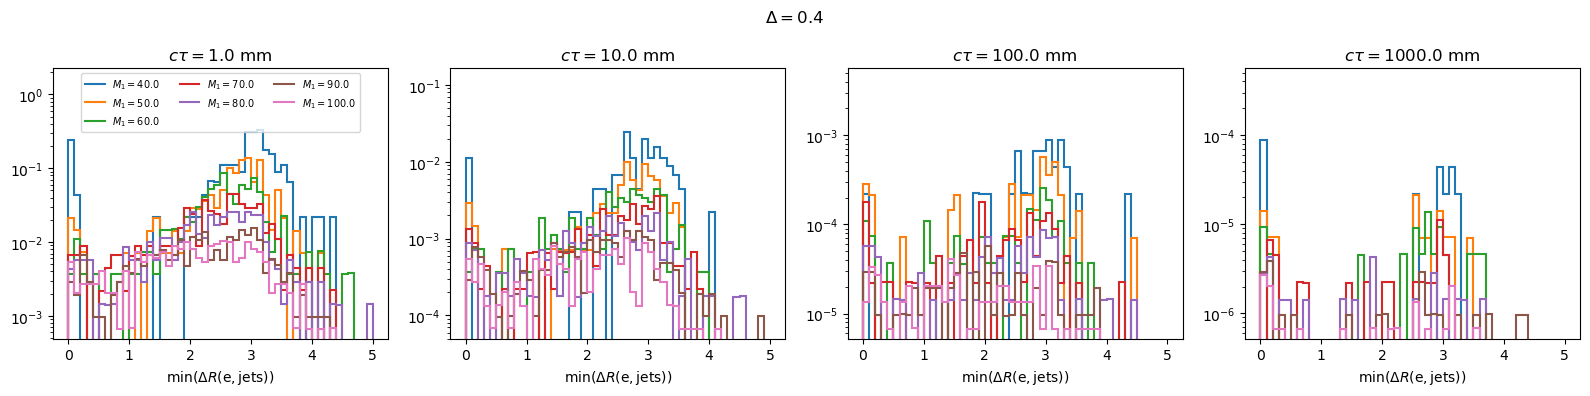

In [63]:
plot("genEE_mindRjGen",None,rej=True,logy=True,rebin=1j)

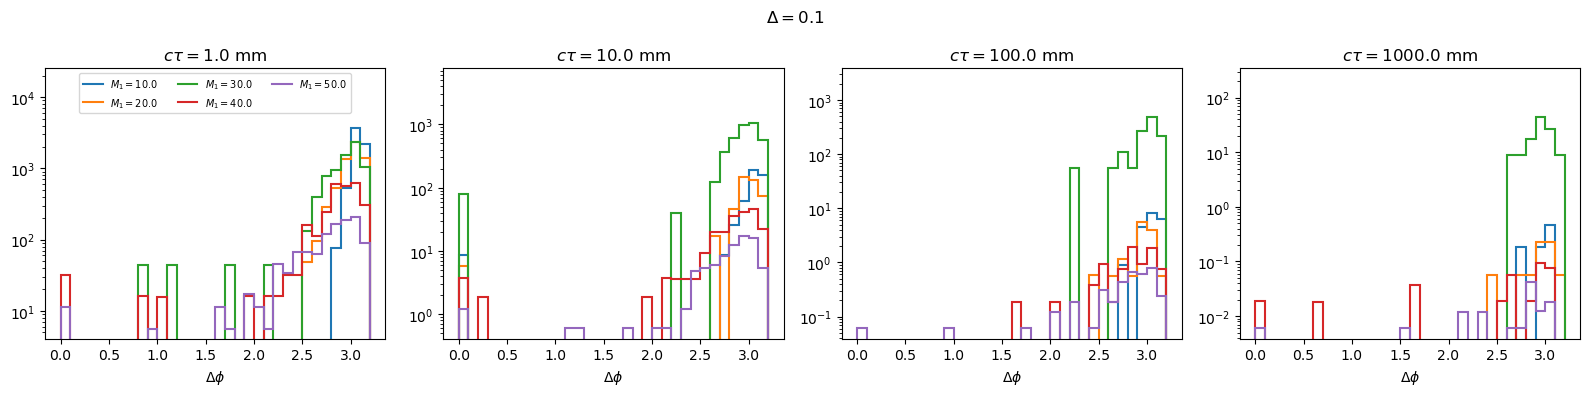

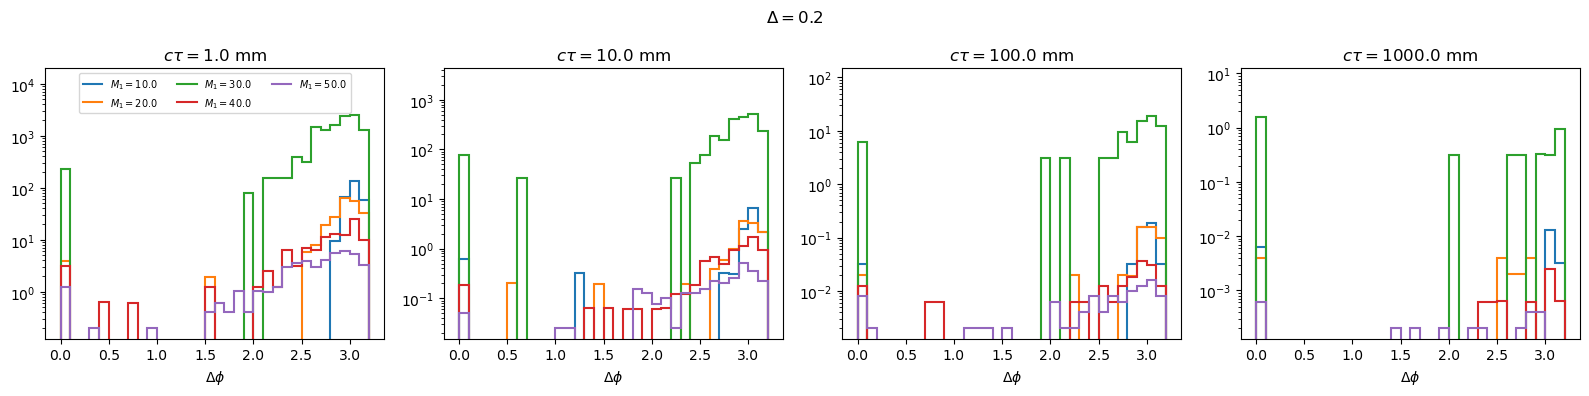

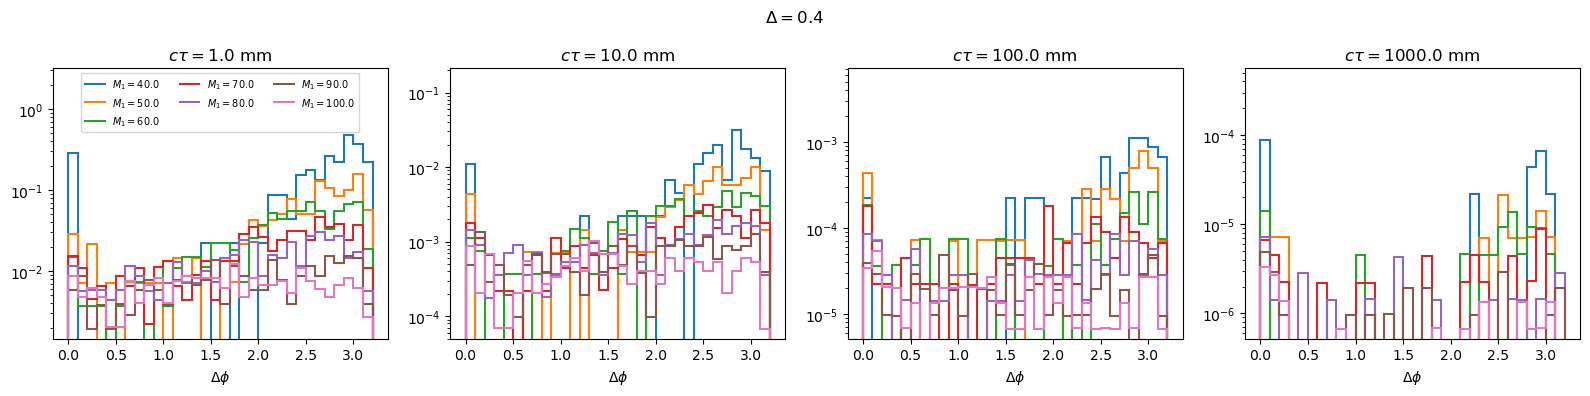

In [64]:
plot("genEE_mindPhiJGen",None,rej=True,logy=True,rebin=1j)